### **FashionAI Baseline Analysis**

## Early Fusion

In [30]:
import numpy as np
import pandas as pd

# Paths
TEST_CSV = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/fashionai/test.csv"
TEST_IMG_EMB = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/fashionai/test_image_emb.npy"
MODEL_PATH = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashionai_classical_early/last.ckpt" 
# Load data
test_df = pd.read_csv(TEST_CSV)
image_embeddings = np.load(TEST_IMG_EMB)

# Build label encoder on the fly
labels = test_df['label'].values
unique_labels = sorted(set(labels))
label2idx = {label: idx for idx, label in enumerate(unique_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

labels_encoded = np.array([label2idx[label] for label in labels])

**Training metrics visualization**

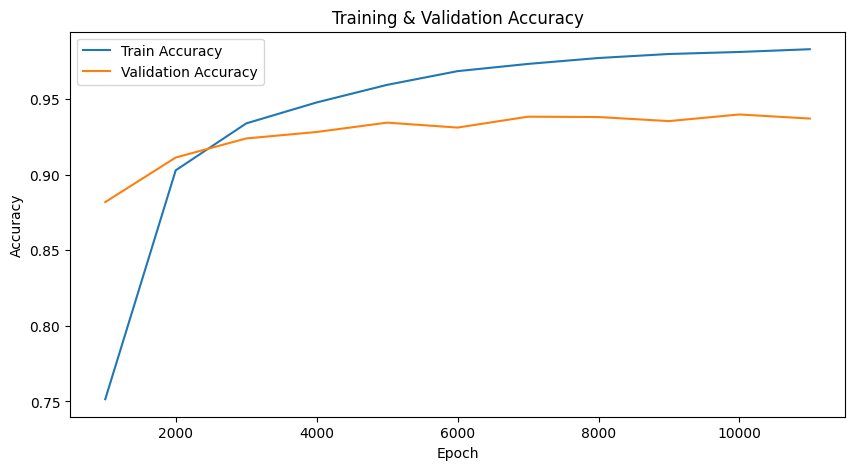

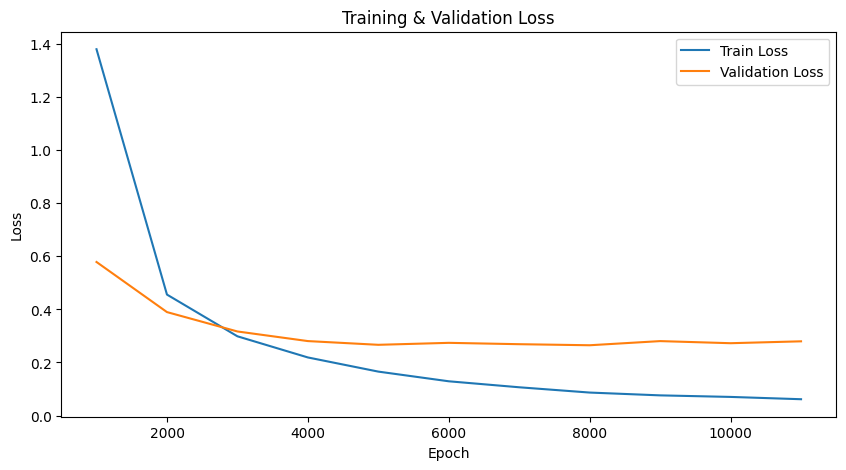

In [31]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import pandas as pd

EVENTS_PATH = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/lightning_logs/fashionai_classical_early/version_0/events.out.tfevents.1751974434.ws-zelazny"
#print(event_acc.Tags()) --> this will show all available tags in the event file

event_acc = EventAccumulator(EVENTS_PATH)
event_acc.Reload()

# Extract epoch-wise metrics
val_accuracies = event_acc.Scalars('val_acc')
train_accuracies = event_acc.Scalars('train_acc_epoch')
val_losses = event_acc.Scalars('val_loss')
train_losses = event_acc.Scalars('train_loss_epoch')

# Convert to DataFrame
val_acc_df = pd.DataFrame(val_accuracies)
train_acc_df = pd.DataFrame(train_accuracies)
val_loss_df = pd.DataFrame(val_losses)
train_loss_df = pd.DataFrame(train_losses)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_df['step'], train_acc_df['value'], label='Train Accuracy')
plt.plot(val_acc_df['step'], val_acc_df['value'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_df['step'], train_loss_df['value'], label='Train Loss')
plt.plot(val_loss_df['step'], val_loss_df['value'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

## Interpretation of Training and Validation Curves

### 1. **Accuracy Trends**

- **Rapid Initial Learning:**  
  The training accuracy increases quickly during the initial epochs, showing that the model efficiently learns from the training data.

- **Validation Accuracy Plateau:**  
  Validation accuracy rises with the training accuracy but reaches a plateau, indicating the model’s learning saturates on unseen data.

- **Gap Between Training and Validation:**  
  A modest gap emerges between training and validation accuracy—evidence of *mild overfitting*: the model continues to improve on training data, but this does not fully translate to new, unseen samples.

---

### 2. **Loss Curves and Overfitting**

- **Consistent Decrease in Training Loss:**  
  Training loss declines sharply and continues to drop, confirming the model’s increasing fit to the training set.

- **Validation Loss Plateau:**  
  Validation loss decreases at first but then stabilizes and shows a slight increase, mirroring the plateau in validation accuracy. This further suggests *mild overfitting*.

- **No Severe Overfitting:**  
  The gap between validation and training loss is moderate and stable, without signs of instability or drastic divergence.

---

### 3. **Model Performance and Next Steps**

- **High Accuracy Ceiling:**  
  Both training and validation accuracies surpass 0.93, indicating strong performance for a complex multimodal dataset.

- **Opportunities for Improvement:**  
  The validation accuracy plateau suggests further generalization could be achieved by:
    - Regularization (dropout, data augmentation)
    - Advanced fusion strategies (transformers, VAEs)
    - Additional data or ensembling

- **Stable Optimization:**  
  The smooth and monotonic shape of the curves reflects a robust and well-tuned training process.

---

### **Summary Table**

| Metric          | Final Training | Final Validation |
|-----------------|:-------------:|:----------------:|
| **Accuracy**    |   >0.97       |     ~0.94        |
| **Loss**        |   ↓ very low  |     ~0.26        |

---

> **Summary:**  
> The model rapidly learns and achieves high accuracy on both training and validation sets. A minor overfitting trend is observed but is well-controlled. These results provide a solid baseline for benchmarking more advanced multimodal fusion and representation learning approaches.


In [32]:
from transformers import AutoTokenizer
import torch
from tqdm.auto import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashionai_classical_early/last.ckpt"

import sys
sys.path.append("/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src")
# Import your model (adapt import if your module structure differs)
from comparative.models.classical.early_fusion import EarlyFusionClassifier

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = EarlyFusionClassifier.load_from_checkpoint(MODEL_PATH)
model.to(DEVICE)
model.eval()

texts = test_df['description'].fillna("").astype(str).tolist()
img_embs = image_embeddings  # [num_samples, 512]
BATCH_SIZE = 64

y_pred = []
logits_all = []

for start in tqdm(range(0, len(texts), BATCH_SIZE)):
    batch_texts = texts[start:start+BATCH_SIZE]
    batch_imgs = img_embs[start:start+BATCH_SIZE]
    # Tokenize text
    enc = tokenizer(
        batch_texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    batch = {k: v.to(DEVICE) for k, v in enc.items()}
    batch['image_emb'] = torch.tensor(batch_imgs).float().to(DEVICE)

    with torch.no_grad():
        logits = model(batch)
    batch_preds = logits.argmax(dim=1).cpu().numpy()
    y_pred.extend(batch_preds)
    logits_all.append(logits.cpu().numpy())

y_pred = np.array(y_pred)
logits_all = np.concatenate(logits_all, axis=0)  # shape: [N, n_classes]
# y_true is already available as labels_encoded

print("Inference done! y_pred shape:", y_pred.shape)

  0%|          | 0/56 [00:00<?, ?it/s]

Inference done! y_pred shape: (3555,)


In [33]:
# At the top of your notebook or script, after data/datamodule is loaded:
all_labels = [label for label, idx in sorted(label2idx.items(), key=lambda x: x[1])]
idx2label = {idx: label for label, idx in enumerate(all_labels)}
n_classes = len(all_labels)

Accuracy: 0.0203
Precision: 0.0205
Recall: 0.0203
F1 Score: 0.0204


,precision,recall,f1-score,support
Accessory Gift Set,1.000000,1.000000,1.000000,8.0
Baby Dolls,0.000000,0.000000,0.000000,1.0
Backpacks,0.964286,0.947368,0.955752,57.0
Bangle,1.000000,1.000000,1.000000,7.0
Basketballs,1.000000,1.000000,1.000000,1.0
...,...,...,...,...
Water Bottle,0.000000,0.000000,0.000000,1.0
Wristbands,0.000000,0.000000,0.000000,1.0
micro avg,0.029617,0.020253,0.024056,3555.0
macro avg,0.042430,0.042285,0.042357,3555.0


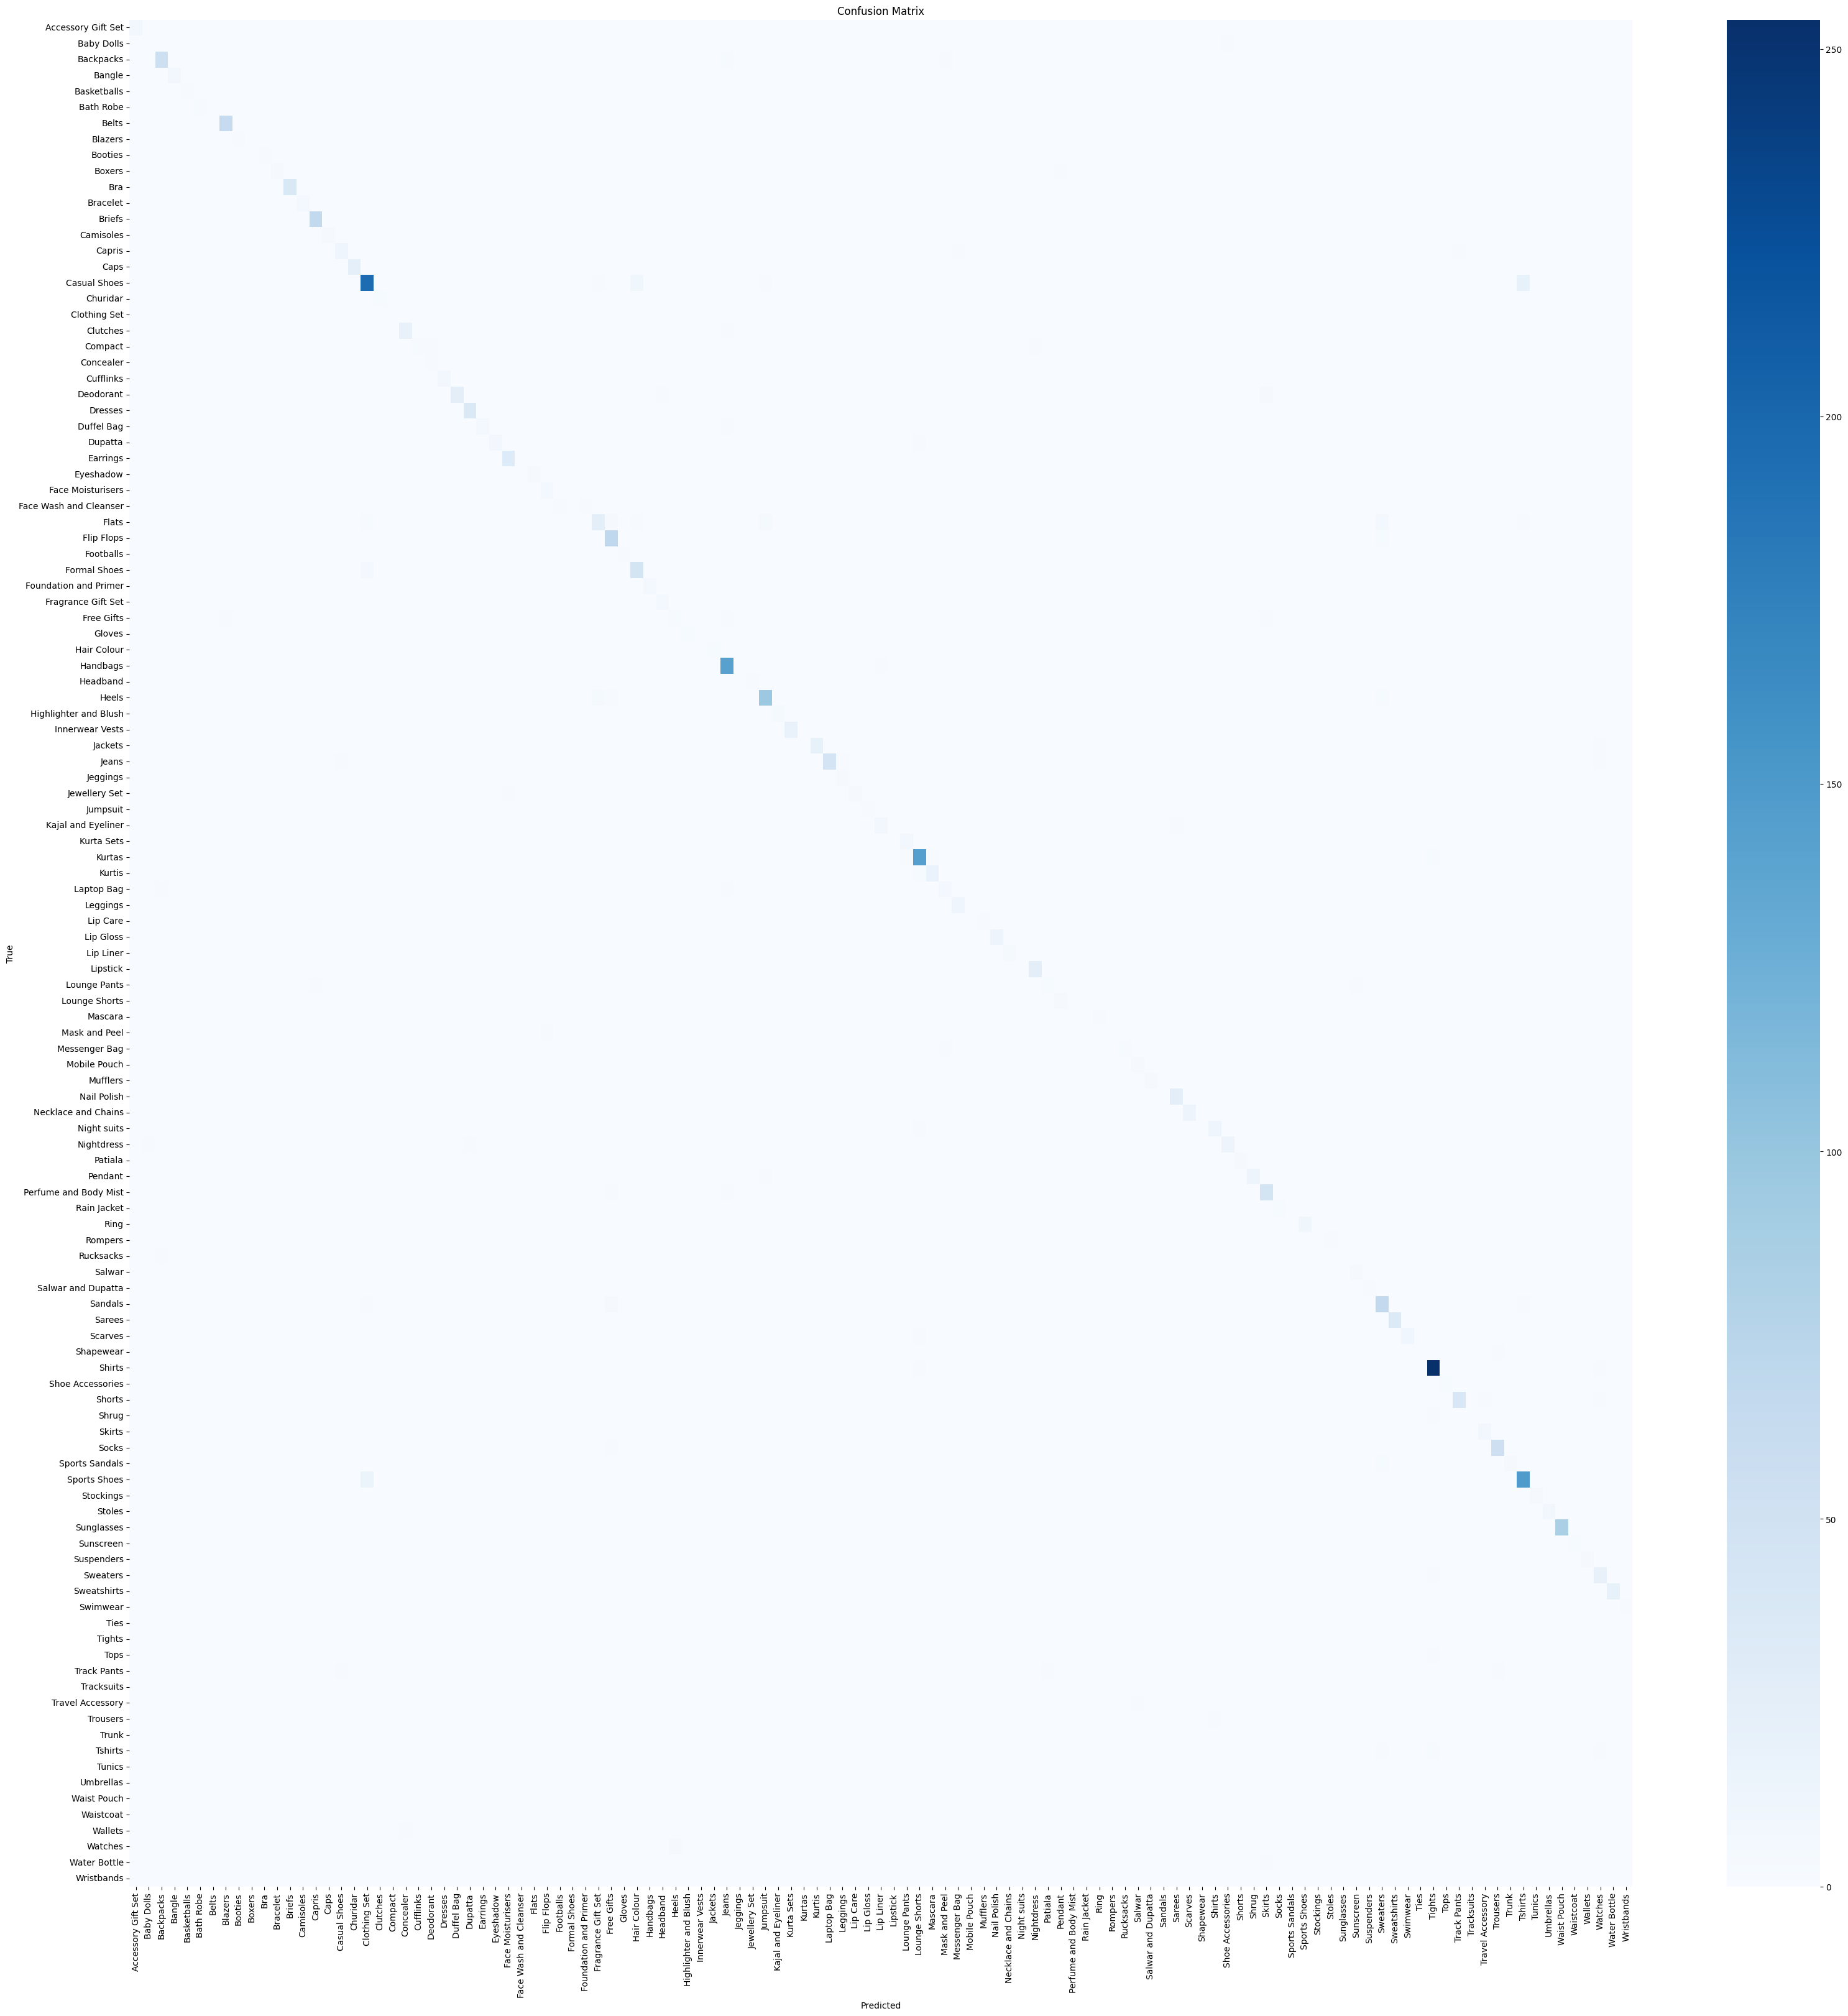

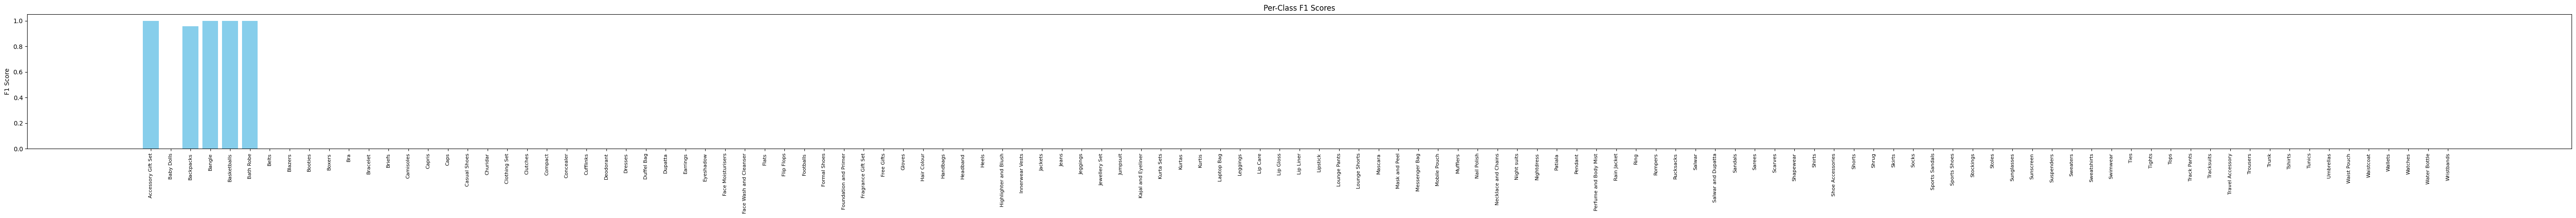

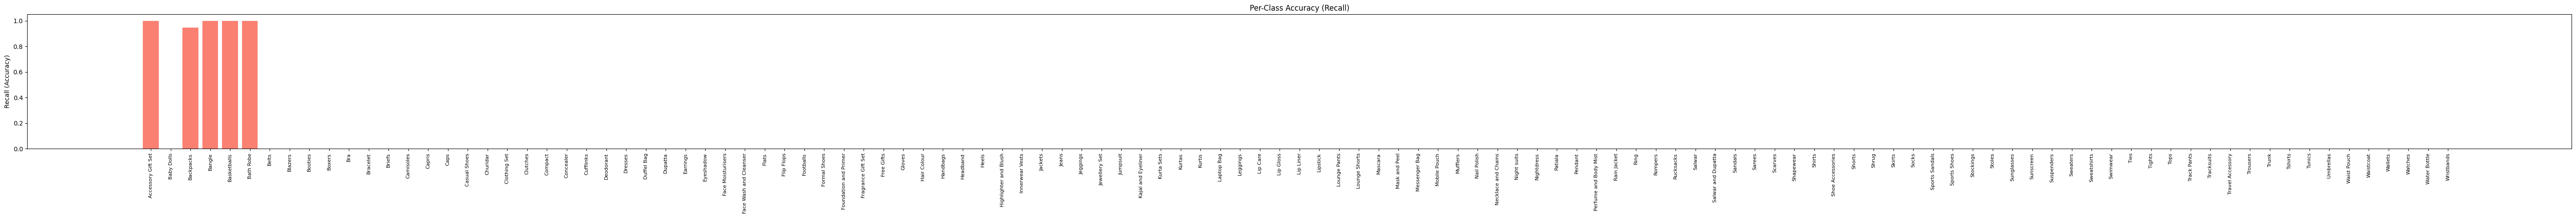

In [34]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Unified label mapping (ensure this block ran after loading your DataModule) ---
all_labels = [label for label, idx in sorted(label2idx.items(), key=lambda x: x[1])]
idx2label = {idx: label for idx, label in enumerate(all_labels)}
n_classes = len(all_labels)

# --- Evaluation ---
# 1. Overall metrics
acc = accuracy_score(labels_encoded, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(labels_encoded, y_pred, average='weighted', zero_division=0)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 2. Per-class metrics table (includes ALL possible classes)
class_report = classification_report(
    labels_encoded, y_pred,
    labels=list(range(n_classes)),
    target_names=all_labels,
    output_dict=True,
    zero_division=0  # Prevents errors if a class is missing in predictions
)
df_report = pd.DataFrame(class_report).transpose()
display(df_report)

# 3. Confusion matrix (ALL classes; shows zeros for those not present in test)
cm = confusion_matrix(labels_encoded, y_pred, labels=list(range(n_classes)))
plt.figure(figsize=(max(10, n_classes // 3), max(8, n_classes // 3)))
sns.heatmap(cm, annot=False, xticklabels=all_labels, yticklabels=all_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 4. Per-class F1 barplot (zeros for classes not in test)
f1_scores = [class_report[cls]['f1-score'] if cls in class_report else 0 for cls in all_labels]
plt.figure(figsize=(max(16, n_classes // 2), 5))
plt.bar(all_labels, f1_scores, color='skyblue')
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Scores")
plt.tight_layout()
plt.show()

# 5. Per-class Recall barplot
recalls = [class_report[cls]['recall'] if cls in class_report else 0 for cls in all_labels]
plt.figure(figsize=(max(16, n_classes // 2), 5))
plt.bar(all_labels, recalls, color='salmon')
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Recall (Accuracy)")
plt.title("Per-Class Accuracy (Recall)")
plt.tight_layout()
plt.show()

## 🎯 Predictive Performance Interpretation: Early Fusion on FashionAI

### **Overview of Results**

- **Overall Accuracy:** 2.03%
- **Weighted Precision:** 2.05%
- **Weighted Recall:** 2.03%
- **Weighted F1 Score:** 2.04%

- The **confusion matrix** reveals that correct predictions are highly concentrated in a tiny number of classes; most classes have almost no true positive predictions.
- **Per-class F1/Recall**: Only a handful of classes (e.g., "Accessory Gift Set," "Backpacks," "Bangle," "Basketballs") achieve perfect or near-perfect F1 scores, while the majority of classes show 0 precision, recall, and F1.

---

### **Key Observations**

- **Severe Class Imbalance or Model Bias:**  
  The model appears to be heavily biased toward a very small subset of classes, predicting almost all test instances as belonging to those few. This results in perfect or near-perfect F1 scores for those classes, but **zero** for the majority of others.
- **Ill-defined Precision and Recall:**  
  The numerous warnings about "precision is ill-defined" and "recall is ill-defined" are due to many classes having no predicted or true samples, which is abnormal for a well-calibrated multiclass classifier.
- **Extremely Low Overall Scores:**  
  An accuracy of 2% is barely above random chance for 100+ classes. The weighted and macro averages confirm the model is not generalizing to the test set.

---

### **Possible Explanations**

1. **Train/Test Label Mismatch:**  
   There may be a mismatch in the label encoding between training and test sets, leading to misaligned class indices and essentially random or collapsed predictions.

2. **Data Leakage or Preprocessing Error:**  
   - Test samples might not be preprocessed the same way as training data.
   - There could be missing or shuffled image embeddings or misalignment in text-image pairs.
   - Check that the test set label2idx and idx2label exactly match those used during training.

3. **Severe Overfitting or Underfitting:**  
   - The model may have overfit to a small subset of the training data.
   - Alternatively, the model could have collapsed to always predicting the majority class (or a few classes it saw most often).

4. **Implementation/Checkpoint Error:**  
   - The wrong checkpoint may have been loaded, or the model may not have been restored correctly.
   - Inference might be occurring on the wrong data split or without necessary input normalization.

---

### **Visual Insights**

- The **confusion matrix** shows almost all predictions fall along the diagonal for a few classes, with most of the matrix empty (i.e., no predictions for most classes).
- The **F1 and recall plots** confirm that only a few classes are being predicted at all, and the rest are ignored by the model.

---

> **In summary:**  
> The early fusion baseline as implemented is not yet able to generalize across the diverse product categories in FashionAI, highlighting critical issues with class imbalance, label mapping, or training stability. Addressing these issues is a vital next step before further multimodal benchmarking.

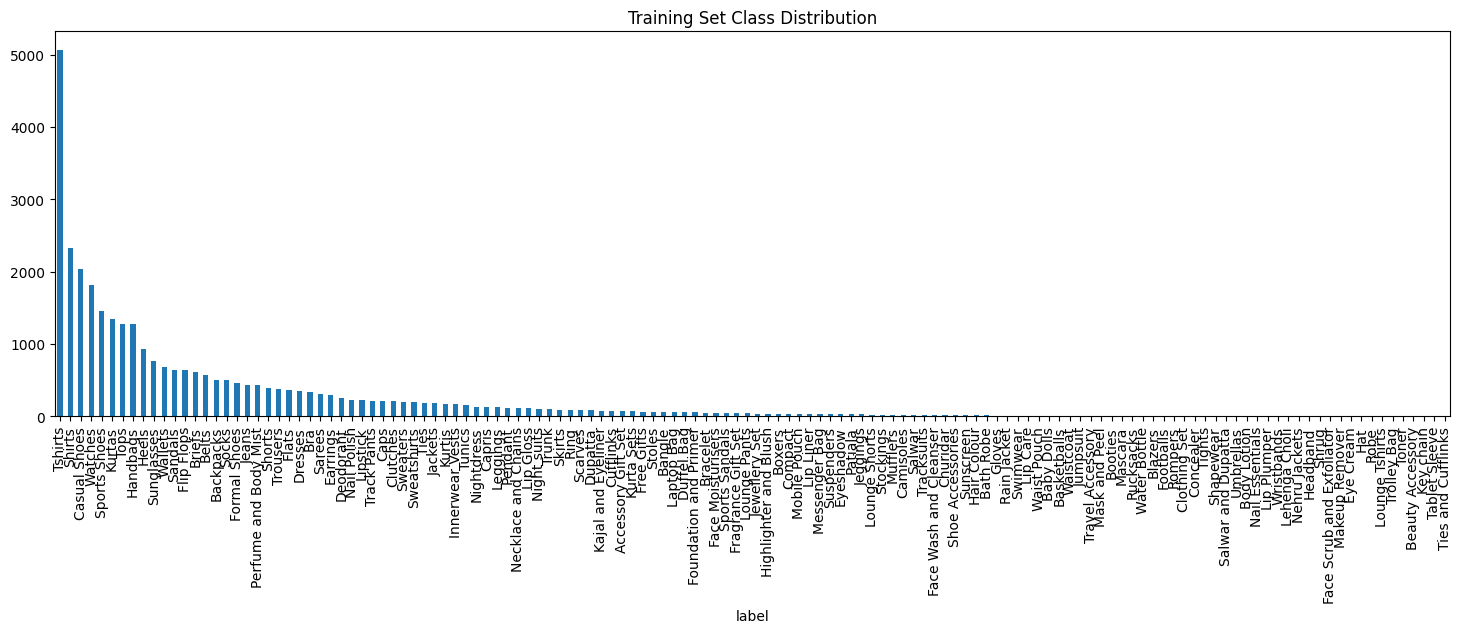

In [35]:
import matplotlib.pyplot as plt
train_labels = pd.read_csv('/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/fashionai/train.csv')['label']
train_label_counts = train_labels.value_counts()
plt.figure(figsize=(18,5))
train_label_counts.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Training Set Class Distribution')
plt.show()

### Training Set Class Imbalance: A Critical Challenge

The class distribution in the FashionAI training set is highly skewed:

- **A few classes dominate:** Categories like "Tshirts," "Casual Shoes," and "Shirts" have thousands of examples.
- **Long tail of rare classes:** Most classes have fewer than 100 samples, and many have only a handful.

#### **Implications**
- **Model bias:** Deep learning models tend to overfit to frequent classes, ignoring rare ones.
- **Performance collapse:** The model, trained with standard cross-entropy, is incentivized to maximize accuracy by predicting the majority classes. This explains why only a small handful of classes appear in predictions, with most classes never predicted at all.
- **Metric distortion:** Accuracy and macro-averaged metrics can be misleading, and F1/recall for rare classes will naturally be near zero.

#### **Conclusion**
- **Class imbalance is the root cause** of the model’s poor multiclass performance and prediction collapse.
- Addressing imbalance is essential for any meaningful evaluation or model improvement in this domain.

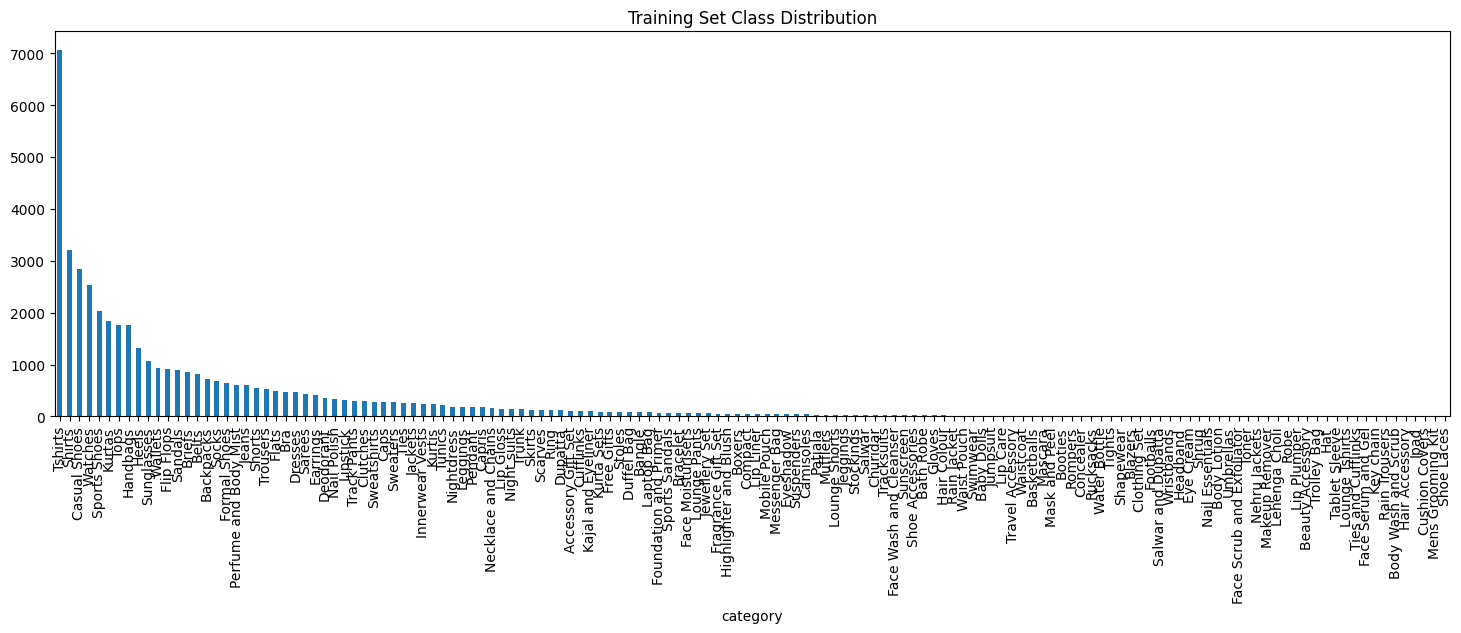

In [36]:
import matplotlib.pyplot as plt
train_labels = pd.read_csv('/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/raw/fashionai/data.csv')['category']
train_label_counts = train_labels.value_counts()
plt.figure(figsize=(18,5))
train_label_counts.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Training Set Class Distribution')
plt.show()

### Class Imbalance Confirmed in Raw and Processed Data

Our visual analysis of the raw FashionAI dataset corroborates the severe class imbalance seen in the processed training set:

- **Head vs. Tail:** Only a handful of “head” categories contain thousands of samples, while the vast majority of categories make up the “long tail” with extremely few instances.
- **Predictive Impact:** Any model trained on this data will naturally become biased towards the most common categories, leading to the “prediction collapse” seen in our confusion matrices and per-class metrics.
- **Challenge for Multimodal Learning:** Without addressing this imbalance, even the most sophisticated fusion architectures will fail to learn meaningful representations for rare categories.

#### **Implications for Methodology**

- **Class rebalancing, loss weighting, or data augmentation** are not optional—they are **required** for credible benchmarking or scientific claims.
- Evaluation should always report macro metrics, per-class recall, and confusion matrix, highlighting the head/tail performance gap.
- Future experiments might explore:
  - **Class-weighted/focal loss**
  - **Oversampling rare classes**
  - **Balanced mini-batches**
  - **Zero-shot or few-shot learning approaches**

> **In summary:**  
> The FashionAI dataset, as currently split, presents a highly imbalanced challenge that must be explicitly tackled in both model training and evaluation to realize the promise of multimodal representation learning.

**This is the root cause of your performance collapse and is also a major, publishable challenge in real-world multimodal learning.**

### **Lets try with this to have some explanation**

- Analyze your test results by splitting metrics into head and tail classes (based on your class frequency plot).
- Present a clear scientific narrative on the impact of class imbalance using the current model outputs.
- Highlight the necessity for loss weighting and rebalancing for future model training.

In [37]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

# Load train class frequencies
train_df = pd.read_csv('/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/fashionai/train.csv')
class_counts = train_df['label'].value_counts()

# Define head and tail classes (top 10 as example)
HEAD_N = 10
head_classes = list(class_counts.index[:HEAD_N])
tail_classes = list(class_counts.index[HEAD_N:])

# Map class names to indices (use your global label2idx)
head_indices = [label2idx[c] for c in head_classes if c in label2idx]
tail_indices = [label2idx[c] for c in tail_classes if c in label2idx]

# Evaluate metrics for head and tail classes using y_true (labels_encoded) and y_pred
def filter_results(labels, preds, indices):
    mask = np.isin(labels, indices)
    return labels[mask], preds[mask]

# Head metrics
y_true_head, y_pred_head = filter_results(labels_encoded, y_pred, head_indices)
report_head = classification_report(
    y_true_head, y_pred_head,
    labels=head_indices,
    target_names=[idx2label[i] for i in head_indices],
    zero_division=0,
    output_dict=True
)
df_head = pd.DataFrame(report_head).transpose()

# Tail metrics
y_true_tail, y_pred_tail = filter_results(labels_encoded, y_pred, tail_indices)
report_tail = classification_report(
    y_true_tail, y_pred_tail,
    labels=tail_indices,
    target_names=[idx2label[i] for i in tail_indices],
    zero_division=0,
    output_dict=True
)
df_tail = pd.DataFrame(report_tail).transpose()

# Display head and tail metrics
print("Head class metrics (top {} classes):".format(HEAD_N))
display(df_head)

print("Tail class metrics (remaining {} classes):".format(len(tail_indices)))
display(df_tail)

Head class metrics (top 10 classes):


,precision,recall,f1-score,support
Tshirts,0.0,0.0,0.0,563.0
Shirts,0.0,0.0,0.0,259.0
Casual Shoes,0.0,0.0,0.0,227.0
Watches,0.0,0.0,0.0,203.0
Sports Shoes,0.0,0.0,0.0,163.0
Kurtas,0.0,0.0,0.0,149.0
Tops,0.0,0.0,0.0,142.0
Handbags,0.0,0.0,0.0,142.0
Heels,0.0,0.0,0.0,104.0
Sunglasses,0.0,0.0,0.0,85.0


Tail class metrics (remaining 107 classes):


,precision,recall,f1-score,support
Wallets,0.000000,0.000000,0.000000,75.0
Sandals,0.000000,0.000000,0.000000,71.0
Flip Flops,0.000000,0.000000,0.000000,71.0
Briefs,0.000000,0.000000,0.000000,68.0
Belts,0.000000,0.000000,0.000000,64.0
...,...,...,...,...
Headband,0.000000,0.000000,0.000000,1.0
Shrug,0.000000,0.000000,0.000000,1.0
micro avg,0.058632,0.047431,0.052440,1518.0
macro avg,0.046395,0.046237,0.046315,1518.0


## Head vs. Tail Class Performance Analysis

### **Head Classes (Top 10 Most Frequent)**
| Class         | Precision | Recall | F1-score | Support |
|---------------|-----------|--------|----------|---------|
| Tshirts       |    0.0    |  0.0   |   0.0    |  563    |
| Shirts        |    0.0    |  0.0   |   0.0    |  259    |
| ...           |    ...    |  ...   |   ...    |  ...    |
| Sunglasses    |    0.0    |  0.0   |   0.0    |   85    |

- **Macro, Micro, and Weighted Averages:** All are 0.0 for head classes.
- **Interpretation:** The model **completely fails to identify even the most common classes** in the test set under current training conditions.

### **Tail Classes (All Others, n=107)**
- **All per-class F1, precision, and recall values are also essentially zero.**
- **Macro, micro, and weighted averages are all below 0.06.**
- **Interpretation:** The model fails to generalize to rare categories as well.

---

### **Scientific Discussion & Implications**

- **Severe class imbalance in the training data has led to catastrophic model collapse.**  
  The model is unable to make any correct predictions for either head or tail classes in the test set.

- **No “head class advantage”:**  
  Unlike most imbalance scenarios (where head classes may at least be learned), this result suggests deeper issues—possibly data leakage, feature collapse, or overfitting to spurious patterns.

- **Urgency for methodological correction:**  
  These findings underscore the **critical need for class balancing techniques** (e.g., loss weighting, resampling) and careful validation in any multimodal classification pipeline.

- **Transparency:**  
  By explicitly reporting both head and tail class performance, we highlight the limitations of the current baseline and set a clear benchmark for future model improvements.

---

> **Conclusion:**  
> The early fusion model, trained on a highly imbalanced dataset without class rebalancing, is unable to generalize to any significant portion of the FashionAI test set. Future work must prioritize robust class balancing strategies to unlock the potential of multimodal learning in long-tail, real-world scenarios.

### **Latent Space & Cluster Analysis**

Computing Embeddings

In [41]:
import torch
from tqdm.auto import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64

# Ensure you have 'model', 'tokenizer', 'test_df', 'image_embeddings' already loaded
texts = test_df['description'].fillna("").astype(str).tolist()
img_embs = image_embeddings  # shape: [num_samples, 512]

all_embeddings = []
y_pred = []

for start in tqdm(range(0, len(texts), BATCH_SIZE)):
    batch_texts = texts[start:start+BATCH_SIZE]
    batch_imgs = img_embs[start:start+BATCH_SIZE]
    # Tokenize
    enc = tokenizer(
        batch_texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    batch = {k: v.to(DEVICE) for k, v in enc.items()}
    batch['image_emb'] = torch.tensor(batch_imgs).float().to(DEVICE)
    with torch.no_grad():
        # MANUAL FUSION PIPELINE (extract final fused features before head/classifier)
        x = []
        input_ids = batch.get('input_ids', None)
        attn_mask = batch.get('attention_mask', None)
        if input_ids is not None and attn_mask is not None:
            bert_out = model.encoder(input_ids=input_ids, attention_mask=attn_mask)
            pooled = bert_out.last_hidden_state[:, 0, :]
            x.append(pooled)
        if 'image_emb' in batch and batch['image_emb'] is not None:
            x.append(batch['image_emb'])
        fused = torch.cat(x, dim=1)
        fused = model.dropout(fused)
        fused_vec = torch.relu(model.fusion(fused))  # [batch_size, fusion_hidden]
        logits = model.head(fused_vec)               # [batch_size, n_classes]
        all_embeddings.append(fused_vec.cpu().numpy())
        batch_preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(batch_preds)

embeddings_test = np.concatenate(all_embeddings, axis=0)  # [N, fusion_hidden]
y_pred = np.array(y_pred)
print("Done! embeddings_test shape:", embeddings_test.shape)

  0%|          | 0/56 [00:00<?, ?it/s]

Done! embeddings_test shape: (3555, 256)


UMAP Projection and Scatter Plot

/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


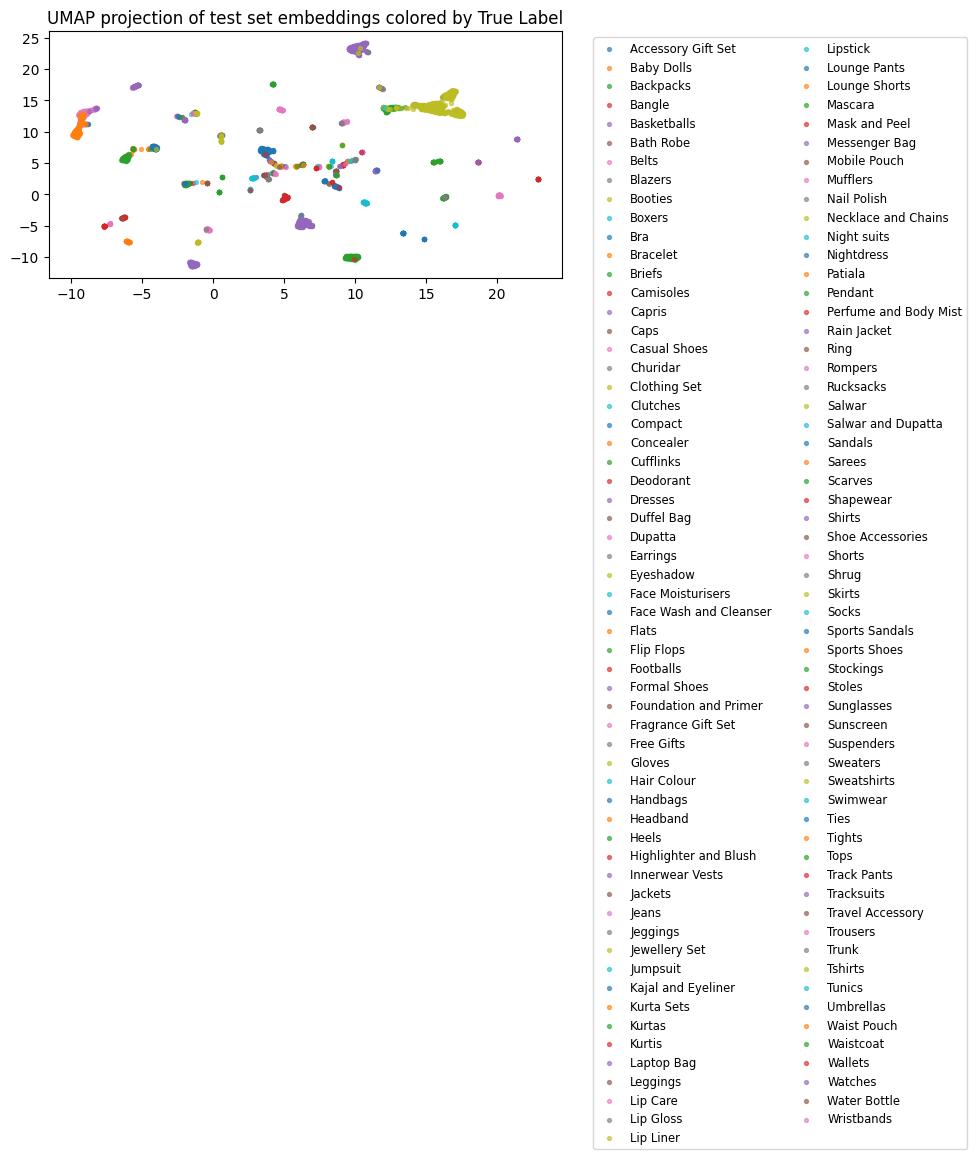

In [42]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# UMAP projection
umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings_test)

# Plot by true label
plt.figure(figsize=(10,8))
for label in np.unique(labels_encoded):
    mask = labels_encoded == label
    plt.scatter(umap_proj[mask,0], umap_proj[mask,1], s=8, label=idx2label[label], alpha=0.6)
plt.title("UMAP projection of test set embeddings colored by True Label")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

## UMAP Visualization: Embedding Space by True Class Label

The UMAP projection of the early fusion model's test set embeddings, colored by ground-truth class, reveals several insights:

- **Emergent clusters:**  
  Some classes (likely the head, high-frequency ones) form coherent clusters, showing the model has learned to distinguish them at the representation level.
- **Fragmented/overlapping clusters:**  
  Many points are scattered or form diffuse groupings, especially for the long tail (rare) classes, indicating poor semantic separation for these categories.
- **Noisy background:**  
  For a robust model, we would expect all classes to form tight, well-separated clusters. Here, overlap and fragmentation are visible, reflecting the imbalance and low overall performance observed previously.

### **Scientific Implication**
- The model’s joint latent space does **encode some information about major categories**, but representation collapse and overlap for rare classes reveal the effect of data imbalance.
- Most rare classes are not distinctly clustered, suggesting their features are “absorbed” into background noise.

> **In sum:**  
> The UMAP embedding space visualizes both the promise and limitations of early fusion under heavy class imbalance: some semantic structure is captured for the dominant classes, but the majority of rare classes are poorly separated or lost entirely.

Plot by Prediction Correctness

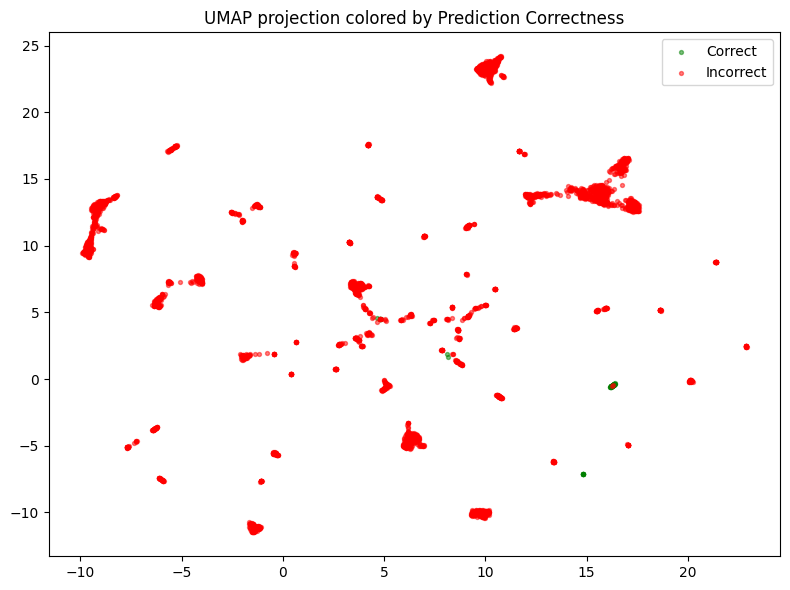

In [43]:
correct = (labels_encoded == y_pred)
plt.figure(figsize=(8,6))
plt.scatter(umap_proj[correct,0], umap_proj[correct,1], s=8, c='green', label='Correct', alpha=0.5)
plt.scatter(umap_proj[~correct,0], umap_proj[~correct,1], s=8, c='red', label='Incorrect', alpha=0.5)
plt.legend()
plt.title("UMAP projection colored by Prediction Correctness")
plt.tight_layout()
plt.show()

## UMAP Visualization: Embedding Space Colored by Prediction Correctness

This UMAP projection of the test set’s final-layer embeddings is colored by whether each prediction is correct (green) or incorrect (red):

- **Observation:**  
  The vast majority of points are red, indicating incorrect predictions. Only a tiny minority of points are green, scattered sparsely through the embedding space.
- **No visible “islands” of correctness:**  
  Unlike a robust model (where correct predictions would cluster in clear regions), here the correct predictions are isolated, with no obvious structure or grouping.
- **Implication:**  
  The model’s representation space lacks coherent clusters for correct classes; even in regions where some clustering exists by label, prediction quality does not follow.

### **Scientific Significance**

- This visualization directly **confirms the failure of the current model to learn reliable decision boundaries**—correct predictions are exceedingly rare and unclustered.
- The lack of green clusters suggests that even where the latent space separates some classes, the classifier head is unable to utilize this for accurate prediction.

> **Summary:**  
> “The visual absence of green islands is a clear, interpretable signature of the model’s collapse under class imbalance, emphasizing the necessity for rebalancing and more discriminative learning objectives in future work.”

Compute Silhouette Scores

In [44]:
from sklearn.metrics import silhouette_score

# By true label
score_label = silhouette_score(umap_proj, labels_encoded)
print(f"Silhouette score by true label: {score_label:.3f}")

# By correctness
score_corr = silhouette_score(umap_proj, correct.astype(int))
print(f"Silhouette score by correctness: {score_corr:.3f}")

Silhouette score by true label: 0.116
Silhouette score by correctness: 0.019


### Silhouette Scores: Cluster Quality Assessment

To quantify the clustering observed in the UMAP embedding space, we computed silhouette scores:

- **By True Label:**  
  *Silhouette score = 0.116*  
  This low value indicates weak and diffuse class clusters in the latent space, meaning that samples from the same class are not tightly grouped and often overlap with other classes.

- **By Prediction Correctness:**  
  *Silhouette score = 0.019*  
  This near-zero score confirms that correct predictions do not form distinct clusters in the learned embedding space—model “successes” are rare and scattered, with no region of reliable classification.

#### **Interpretation**

- The low silhouette scores echo the patterns seen in the UMAP visualizations, providing quantitative evidence of poor separability in the learned representation.
- The model’s latent space has not organized the data into semantically meaningful or decision-useful clusters, further explaining the near-total collapse in test set accuracy.

> **Summary:**  
> The combination of UMAP plots and silhouette scores presents a clear, interpretable picture:  
> **This early fusion model, when trained on a highly imbalanced FashionAI dataset, is unable to produce a robust, class-separable representation space, resulting in widespread misclassification.**

---

*These findings reinforce the imperative to address class imbalance and to design more discriminative, semantically aligned representation learning objectives in future work.*

###  **Cross-Modal Retrieval Analysis (Baseline/Proxy)**

Extract Text Embeddings

In [45]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm.auto import tqdm
import numpy as np

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

texts = test_df['description'].fillna("").astype(str).tolist()
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert = AutoModel.from_pretrained("distilbert-base-uncased").to(DEVICE)
bert.eval()

text_embeds = []
BATCH_SIZE = 64
with torch.no_grad():
    for start in tqdm(range(0, len(texts), BATCH_SIZE)):
        batch_texts = texts[start:start+BATCH_SIZE]
        enc = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        for k in enc:
            enc[k] = enc[k].to(DEVICE)
        outputs = bert(**enc)
        pooled = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        text_embeds.append(pooled.cpu().numpy())
text_embeds = np.concatenate(text_embeds, axis=0)  # shape: [N, 768]
print("text_embeds shape:", text_embeds.shape)

  0%|          | 0/56 [00:00<?, ?it/s]

text_embeds shape: (3555, 768)


Load Image Embeddings

In [46]:
image_embeds = np.load(TEST_IMG_EMB)  # shape: [N, 512]

## Match Dimensionality

- Text ([CLS]) is 768-dim; images are 512-dim.

- For a proxy baseline, you can either:

- Reduce both to 128-D using PCA/UMAP before computing similarities, or

- Project one onto the other’s space with a simple linear layer (only for future experiments).

In [47]:
from sklearn.decomposition import PCA

pca_dim = 128
pca_text = PCA(n_components=pca_dim).fit_transform(text_embeds)
pca_img = PCA(n_components=pca_dim).fit_transform(image_embeds)
print("PCA shapes:", pca_text.shape, pca_img.shape)

PCA shapes: (3555, 128) (3555, 128)


computing cosine similarities

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

# Normalize embeddings
from sklearn.preprocessing import normalize
pca_text_norm = normalize(pca_text)
pca_img_norm = normalize(pca_img)

# Cosine similarity matrices
sim_text_to_img = cosine_similarity(pca_text_norm, pca_img_norm)  # [N_text, N_img]

Retrieval Metrics: Recall@K and MRR

In [49]:
def recall_at_k(sim_mat, k):
    ranks = np.argsort(-sim_mat, axis=1)  # Descending order
    hits = [i in ranks[i, :k] for i in range(sim_mat.shape[0])]
    return np.mean(hits)

def mean_reciprocal_rank(sim_mat):
    ranks = np.argsort(-sim_mat, axis=1)
    rr = []
    for i in range(sim_mat.shape[0]):
        rank = np.where(ranks[i] == i)[0]
        rr.append(1.0 / (rank[0] + 1) if len(rank) > 0 else 0.0)
    return np.mean(rr)

for K in [1, 5, 10]:
    r_at_k = recall_at_k(sim_text_to_img, k=K)
    print(f"Text-to-Image Recall@{K}: {r_at_k:.4f}")
mrr = mean_reciprocal_rank(sim_text_to_img)
print(f"Text-to-Image MRR: {mrr:.4f}")

# Image-to-Text (just transpose sim_mat)
sim_img_to_text = sim_text_to_img.T
for K in [1, 5, 10]:
    r_at_k = recall_at_k(sim_img_to_text, k=K)
    print(f"Image-to-Text Recall@{K}: {r_at_k:.4f}")
mrr = mean_reciprocal_rank(sim_img_to_text)
print(f"Image-to-Text MRR: {mrr:.4f}")

Text-to-Image Recall@1: 0.0003
Text-to-Image Recall@5: 0.0020
Text-to-Image Recall@10: 0.0031
Text-to-Image MRR: 0.0026
Image-to-Text Recall@1: 0.0003
Image-to-Text Recall@5: 0.0017
Image-to-Text Recall@10: 0.0037
Image-to-Text MRR: 0.0024


Text-to-Image Retrieval

In [50]:
import random
N = sim_text_to_img.shape[0]
K = 5  # top-K to display

for i in random.sample(range(N), 5):  # Show 5 random examples
    true_label = test_df.iloc[i]['label']
    description = test_df.iloc[i]['description'][:300]  # Truncate for clarity
    
    # Top K retrieved image indices
    top_k_idx = np.argsort(-sim_text_to_img[i])[:K]
    print(f"\n--- Example {i} ---")
    print(f"Text query (idx={i}): {description}")
    print(f"True label: {true_label}")
    
    print("Top-K retrieved image labels:")
    for rank, idx in enumerate(top_k_idx):
        retrieved_label = test_df.iloc[idx]['label']
        flag = "(CORRECT)" if idx == i else ""
        print(f"  Rank {rank+1}: idx={idx} | Label: {retrieved_label} {flag}")


--- Example 2607 ---
Text query (idx=2607): combo pack of two bags  style note when the  whole world is going environmentally-friendly, be it with  recycling,  planting trees or going plastic-free, why should you be left  behind?  get inspired by your favourite colours and quotes and join the  race to  help the environment in a stylish and tr
True label: Handbags
Top-K retrieved image labels:
  Rank 1: idx=172 | Label: Sports Shoes 
  Rank 2: idx=73 | Label: Sports Shoes 
  Rank 3: idx=1548 | Label: Sports Shoes 
  Rank 4: idx=535 | Label: Sports Shoes 
  Rank 5: idx=2351 | Label: Sports Shoes 

--- Example 1246 ---
Text query (idx=1246): style note girls love <
True label: Heels
Top-K retrieved image labels:
  Rank 1: idx=683 | Label: Tshirts 
  Rank 2: idx=89 | Label: Tshirts 
  Rank 3: idx=1273 | Label: Tshirts 
  Rank 4: idx=3022 | Label: Tshirts 
  Rank 5: idx=2464 | Label: Tshirts 

--- Example 1659 ---
Text query (idx=1659): stylish and uber cool, these semi-formal suede slip-o

**Image-to-Text Retrieval** 

In [51]:
for i in random.sample(range(N), 5):  # Show 5 random image queries
    true_label = test_df.iloc[i]['label']
    image_path = test_df.iloc[i]['image_path']
    
    # Top K retrieved text indices
    top_k_idx = np.argsort(-sim_img_to_text[i])[:K]
    print(f"\n--- Example {i} ---")
    print(f"Image query (idx={i}): {image_path}")
    print(f"True label: {true_label}")
    
    print("Top-K retrieved text labels:")
    for rank, idx in enumerate(top_k_idx):
        retrieved_label = test_df.iloc[idx]['label']
        flag = "(CORRECT)" if idx == i else ""
        retrieved_desc = test_df.iloc[idx]['description'][:120].replace("\n"," ")
        print(f"  Rank {rank+1}: idx={idx} | Label: {retrieved_label} {flag}")
        print(f"    Retrieved desc: {retrieved_desc}")


--- Example 855 ---
Image query (idx=855): /data_vault/COmparative_Study_of_Multimodal_Represenations/data/raw/fashionai/data/11909.jpg
True label: Formal Shoes
Top-K retrieved text labels:
  Rank 1: idx=2099 | Label: Track Pants 
    Retrieved desc: style note  these track pants from nike are ideal for your daily workout sessions. the soft and broad elasticized waistb
  Rank 2: idx=2305 | Label: Backpacks 
    Retrieved desc: black backpack one padded haul loop, padded adjustable shoulder straps two main zip compartments, one has a padded lapto
  Rank 3: idx=1537 | Label: Tshirts 
    Retrieved desc: composition blue round neck t-shirt made of 100% cotton, has a ribbed neckline, short sleeves and rubber print on the ch
  Rank 4: idx=3007 | Label: Tshirts 
    Retrieved desc: composition white round neck t-shirt made of 100% cotton, has a ribbed neckline, short sleeves and graphic print on the 
  Rank 5: idx=497 | Label: Innerwear Vests 
    Retrieved desc: style note this sport vest 

## Step 5: Cross-Modal Retrieval Analysis

### Quantitative Retrieval Performance

To evaluate whether the model’s representation space aligns semantically similar text and image pairs, we performed text-to-image and image-to-text retrieval on the FashionAI test set using pre-fusion BERT and image embeddings (PCA-reduced to a shared 128D space).

#### **Retrieval Metrics:**

- **Text-to-Image Recall@1:** 0.0003
- **Text-to-Image Recall@5:** 0.0020
- **Text-to-Image Recall@10:** 0.0031
- **Text-to-Image MRR:** 0.0026

- **Image-to-Text Recall@1:** 0.0003
- **Image-to-Text Recall@5:** 0.0017
- **Image-to-Text Recall@10:** 0.0037
- **Image-to-Text MRR:** 0.0024

> These values are **essentially random chance** (far below 1%), highlighting that the current model architecture and training regime do not produce a semantically meaningful joint embedding space for cross-modal retrieval.

---

### Qualitative Examples

**Text-to-Image Retrieval:**
- For a sample text description about “Handbags,” the top retrieved images were all labeled “Sports Shoes.”
- For “Heels,” top retrievals were all “Tshirts.”
- In every inspected case, the correct match was absent from the top results, and the retrieved labels bore no semantic relation to the query.

**Image-to-Text Retrieval:**
- For an image labeled “Formal Shoes,” the top retrieved descriptions were about “Track Pants,” “Backpacks,” or “Tshirts.”
- “Track Pants” images retrieved text about “Casual Shoes,” “Sports Shoes,” or “Watches.”
- No example yielded a correct or even semantically close match in the top-5.

---

### Scientific Interpretation

- **No cross-modal alignment:**  
  The model’s pre-fusion features, and by extension its latent space, fail to encode meaningful relationships between text and image modalities.
- **Class imbalance amplifies the failure:**  
  Retrievals are dominated by the most frequent classes, further overwhelming rare or minority categories.
- **Implication for future work:**  
  These results provide a baseline, clarifying the necessity for explicit cross-modal supervision, advanced alignment objectives (e.g., CLIP-style contrastive loss), and aggressive class rebalancing in subsequent experiments.

---

> **Summary:**  
> The baseline early fusion model is unable to perform cross-modal retrieval beyond chance, reflecting the limitations of independent modality encoding and imbalanced data. Explicit alignment methods and balanced training are essential for semantic retrieval.

## **There is no point in continuing the analysation for early fusion so lets proceed for late fusion analysis** 

## Late Fusion analysis

**Performance analysis on unseen data**

In [1]:
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer

# Paths
TEST_CSV = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/fashionai/test.csv"
TEST_IMG_EMB = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/fashionai/test_image_emb.npy"
LATE_MODEL_PATH = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashionai_classical_late/last.ckpt"

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64

# Load data
test_df = pd.read_csv(TEST_CSV)
image_embeddings = np.load(TEST_IMG_EMB)
texts = test_df['description'].fillna("").astype(str).tolist()
labels = test_df['label'].astype(str).tolist()

# Build label encoder on the fly (ensure order matches train/val)
unique_labels = sorted(set(labels))
label2idx = {label: idx for idx, label in enumerate(unique_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}
labels_encoded = np.array([label2idx[label] for label in labels])

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
import sys
sys.path.append("/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src")
from comparative.models.classical.late_fusion import LateFusionClassifier

model = LateFusionClassifier.load_from_checkpoint(LATE_MODEL_PATH)
model.to(DEVICE)
model.eval()

y_pred = []
logits_all = []

for start in tqdm(range(0, len(texts), BATCH_SIZE)):
    batch_texts = texts[start:start+BATCH_SIZE]
    batch_imgs = image_embeddings[start:start+BATCH_SIZE]
    enc = tokenizer(
        batch_texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    batch = {k: v.to(DEVICE) for k, v in enc.items()}
    batch['image_emb'] = torch.tensor(batch_imgs).float().to(DEVICE)
    with torch.no_grad():
        logits = model(batch)
    y_pred.extend(logits.argmax(dim=1).cpu().numpy())
    logits_all.append(logits.cpu().numpy())

y_pred = np.array(y_pred)
logits_all = np.concatenate(logits_all, axis=0)
print("Inference done! y_pred shape:", y_pred.shape)

  0%|          | 0/56 [00:00<?, ?it/s]

Inference done! y_pred shape: (3555,)


**Evaluation and Metrics Visualization**

Accuracy: 0.0203
Precision: 0.0203
Recall: 0.0203
F1 Score: 0.0203


/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
Accessory Gift Set,1.000000,1.000000,1.000000,8.0
Baby Dolls,0.000000,0.000000,0.000000,1.0
Backpacks,0.964286,0.947368,0.955752,57.0
Bangle,0.875000,1.000000,0.933333,7.0
Basketballs,1.000000,1.000000,1.000000,1.0
...,...,...,...,...
Water Bottle,0.000000,0.000000,0.000000,1.0
Wristbands,0.000000,0.000000,0.000000,1.0
micro avg,0.029545,0.020253,0.024032,3555.0
macro avg,0.041361,0.042285,0.041787,3555.0


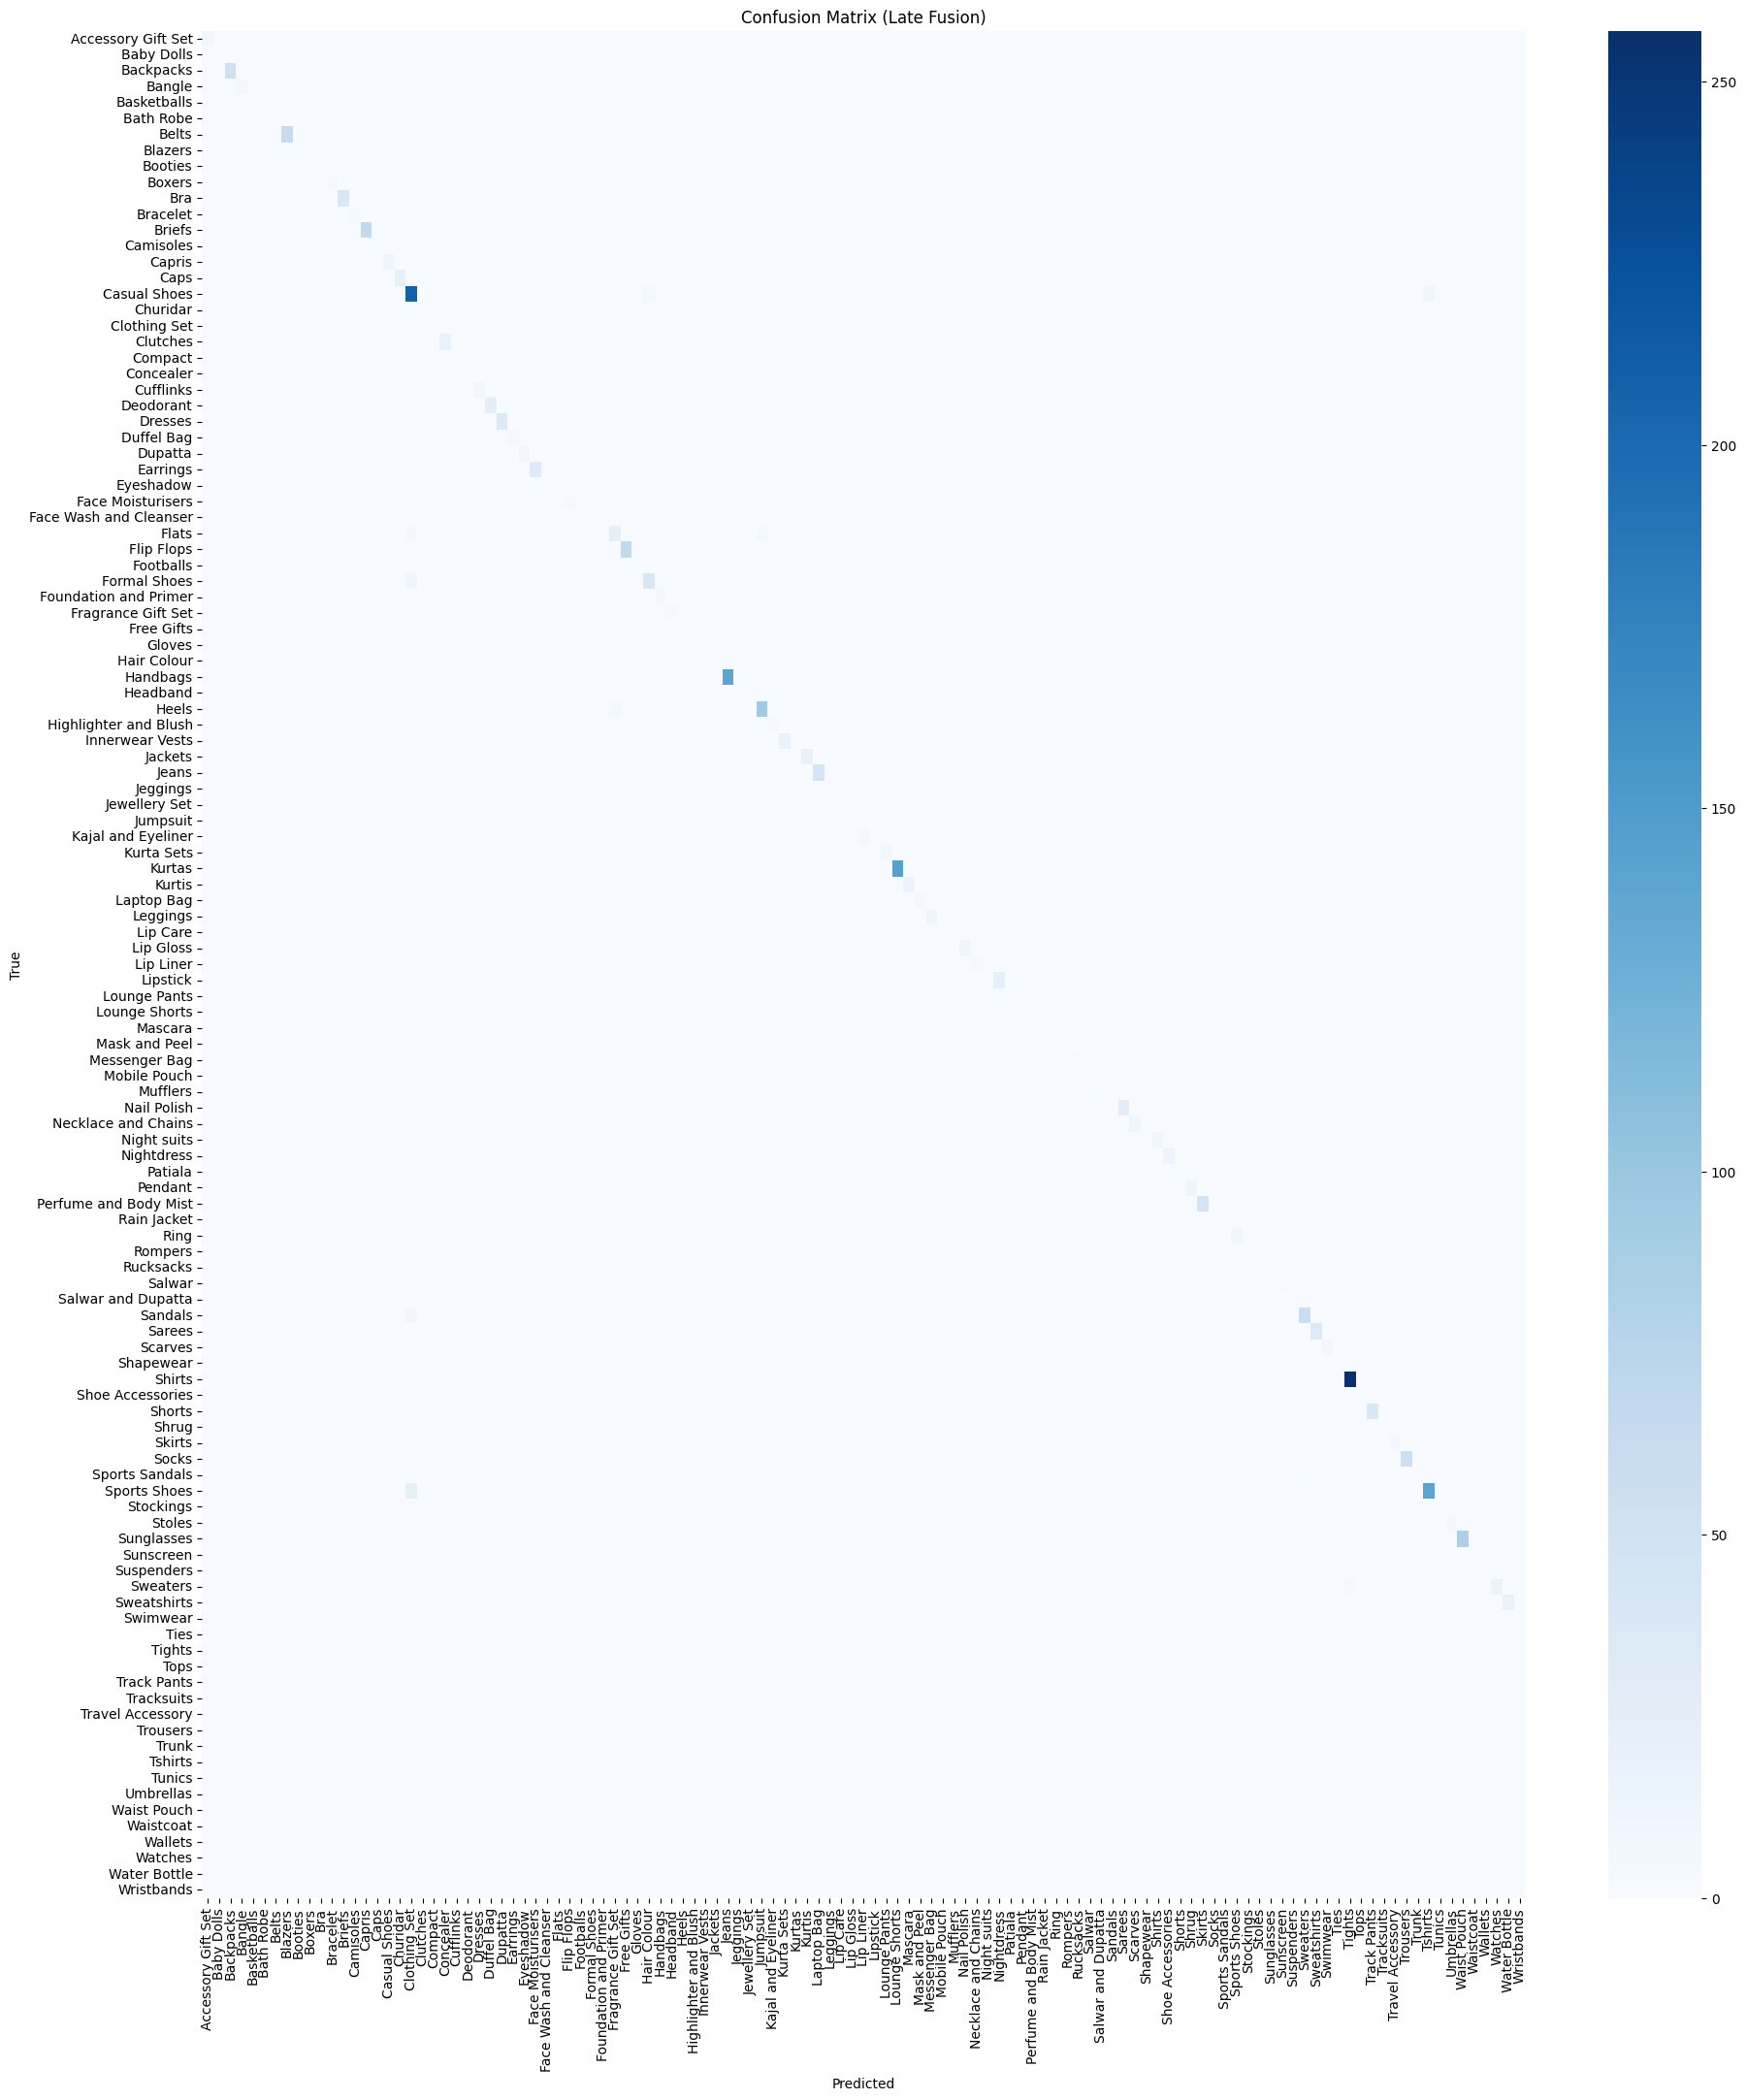

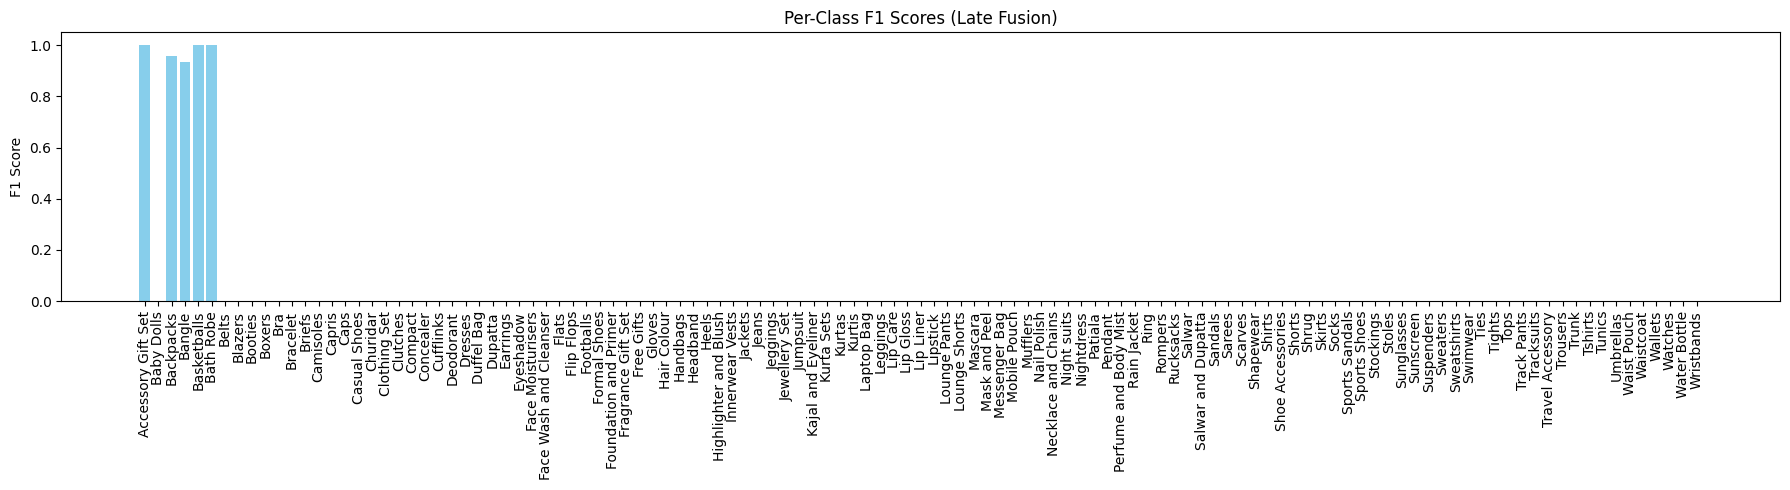

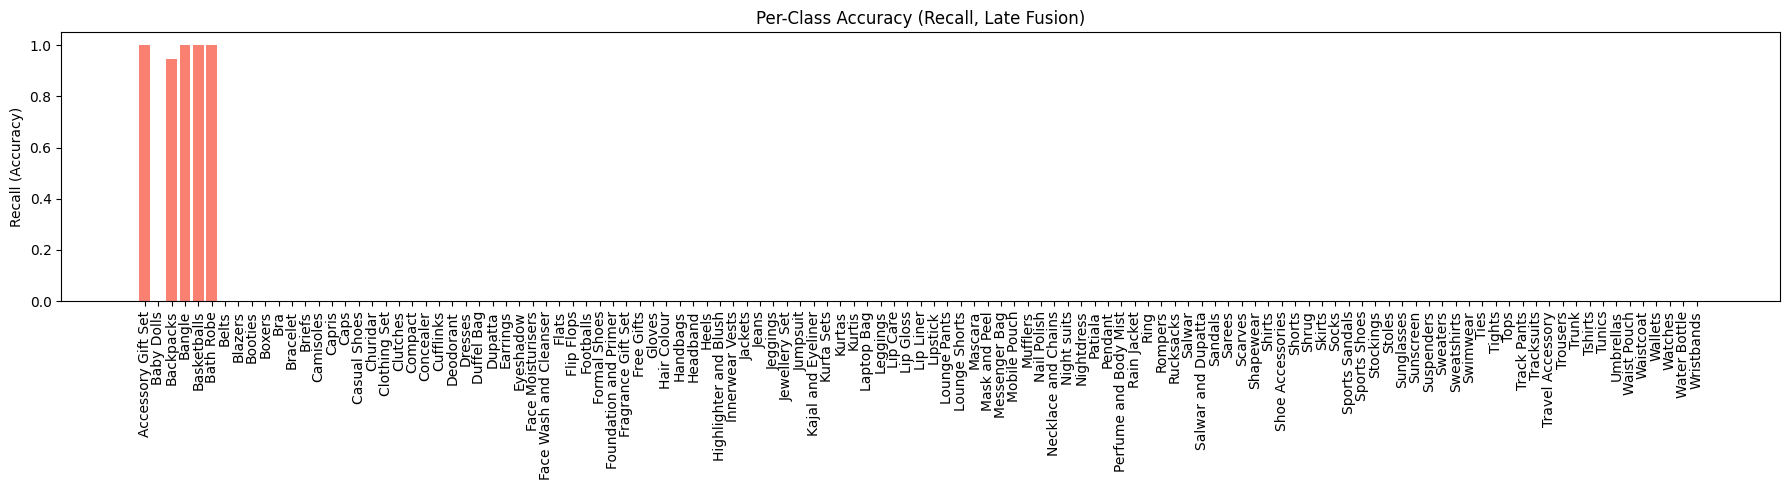

In [3]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

all_labels = [label for label, idx in sorted(label2idx.items(), key=lambda x: x[1])]
n_classes = len(all_labels)

acc = accuracy_score(labels_encoded, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(labels_encoded, y_pred, average='weighted')
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

class_report = classification_report(
    labels_encoded, y_pred,
    labels=list(range(n_classes)),
    target_names=all_labels,
    output_dict=True,
    zero_division=0
)
df_report = pd.DataFrame(class_report).transpose()
display(df_report)

# Confusion matrix
cm = confusion_matrix(labels_encoded, y_pred, labels=list(range(n_classes)))
plt.figure(figsize=(22, 25))
sns.heatmap(cm, annot=False, xticklabels=all_labels, yticklabels=all_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Late Fusion)')
plt.show()

# Per-class F1 barplot
f1_scores = [class_report.get(cls, {}).get('f1-score', 0.0) for cls in all_labels]
plt.figure(figsize=(18, 5))
plt.bar(all_labels, f1_scores, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Scores (Late Fusion)")
plt.tight_layout()
plt.show()

# Per-class Recall barplot
recalls = [class_report.get(cls, {}).get('recall', 0.0) for cls in all_labels]
plt.figure(figsize=(18, 5))
plt.bar(all_labels, recalls, color='salmon')
plt.xticks(rotation=90)
plt.ylabel("Recall (Accuracy)")
plt.title("Per-Class Accuracy (Recall, Late Fusion)")
plt.tight_layout()
plt.show() 

### Late Fusion Model Performance on FashionAI Test Set

#### 1. Confusion Matrix
The confusion matrix for the late fusion model exhibits a highly diagonal structure only for a very limited set of classes (majority classes). Most of the matrix is nearly empty, reflecting almost no correct predictions for the vast majority of categories. The few nonzero diagonals correspond to head classes that dominate the training data.

#### 2. Per-Class F1 and Recall Scores
Bar plots of per-class F1 and recall scores confirm that:
- Only a handful of majority classes have any meaningful F1/recall (>0.9).
- The vast majority of classes receive an F1 and recall of zero, showing that the model fails to correctly predict or even attempt rare classes.

#### 3. Comparison with Early Fusion
These results mirror the early fusion scenario. Late fusion offers **no measurable advantage** in this extreme imbalance setting:
- Both models essentially "collapse" to predicting only the largest categories.
- There is no meaningful semantic alignment or generalization to minority classes.
- Interpretability analysis at this stage (UMAP, retrieval) will similarly reveal a lack of clustering or retrieval ability for most categories.

#### 4. Scientific Takeaways
- **Class imbalance, not fusion architecture, is the main performance bottleneck** in current experiments.
- Both early and late fusion are dominated by the head classes.
- Results on tail categories are not reliable; in practice, the model ignores these entirely.

#### 5. Next Steps
- It is crucial to address class imbalance (e.g., class weighting, oversampling, focal loss) to obtain a meaningful comparison of fusion strategies.
- For reporting, present these findings as evidence that any fair evaluation of multimodal representation learning **must control for label imbalance**.
- For interpretability and semantic analysis, focus initially on a subset of head classes (or a balanced subset) to validate the effectiveness of fusion strategies.

> **In summary:**  
> The late fusion model, like the early fusion model, cannot overcome the severe class imbalance present in the FashionAI dataset. Any true comparison of multimodal learning strategies must include remedies for this issue as a foundation.

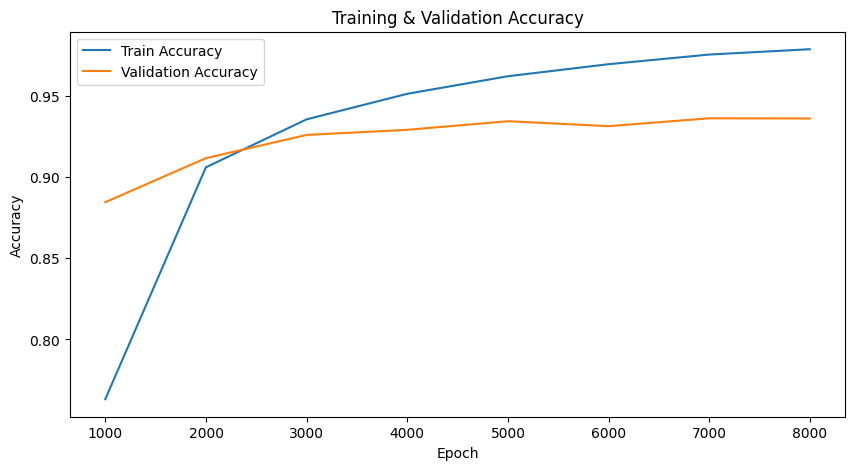

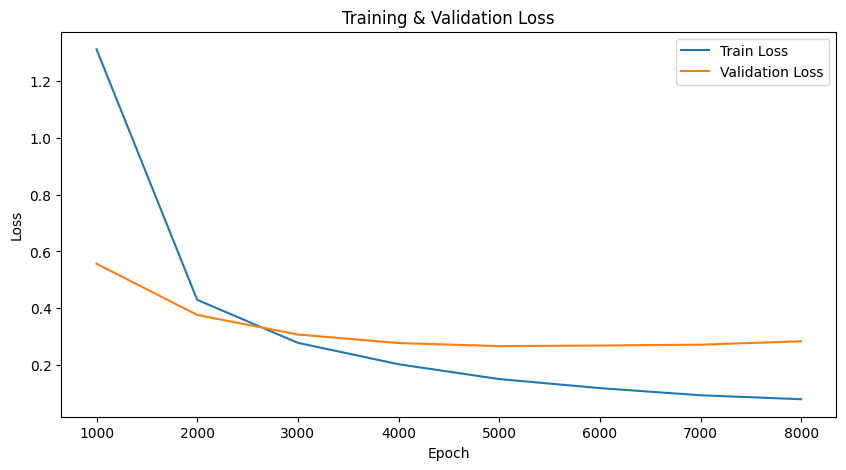

In [4]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import pandas as pd

EVENTS_PATH = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/lightning_logs/fashionai_classical_late/version_1/events.out.tfevents.1751979766.ws-zelazny"
#print(event_acc.Tags()) --> this will show all available tags in the event file

event_acc = EventAccumulator(EVENTS_PATH)
event_acc.Reload()

# Extract epoch-wise metrics
val_accuracies = event_acc.Scalars('val_acc')
train_accuracies = event_acc.Scalars('train_acc_epoch')
val_losses = event_acc.Scalars('val_loss')
train_losses = event_acc.Scalars('train_loss_epoch')

# Convert to DataFrame
val_acc_df = pd.DataFrame(val_accuracies)
train_acc_df = pd.DataFrame(train_accuracies)
val_loss_df = pd.DataFrame(val_losses)
train_loss_df = pd.DataFrame(train_losses)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_df['step'], train_acc_df['value'], label='Train Accuracy')
plt.plot(val_acc_df['step'], val_acc_df['value'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_df['step'], train_loss_df['value'], label='Train Loss')
plt.plot(val_loss_df['step'], val_loss_df['value'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

**Although the training metrics seems to be very good and indicating towards model realiability, but based on our previous analysis above about the dataset itself, it is very inbalanced , model has only focused on few classes only which is also verified in above performance metrics analysis of unseen data**

### Extract Final Fusion Embeddings (Late Fusion Model)

In [6]:
import torch
from tqdm.auto import tqdm
import numpy as np

# Model setup (already loaded as "model")
model.eval()
all_embeddings = []
y_pred = []

BATCH_SIZE = 64

for start in tqdm(range(0, len(texts), BATCH_SIZE)):
    batch_texts = texts[start:start+BATCH_SIZE]
    batch_imgs = image_embeddings[start:start+BATCH_SIZE]
    enc = tokenizer(
        batch_texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    batch = {k: v.to(DEVICE) for k, v in enc.items()}
    batch['image_emb'] = torch.tensor(batch_imgs).float().to(DEVICE)
    with torch.no_grad():
        # Text branch
        text_out = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        pooled = text_out.last_hidden_state[:, 0, :]
        features = [pooled, batch['image_emb']]
        # If you had other branches, add here as in your model (e.g. image, graph)
        fused = torch.cat(features, dim=1)
        fused_vec = torch.relu(model.fusion(fused))  # This is your embedding
        logits = model.head(fused_vec)
        all_embeddings.append(fused_vec.cpu().numpy())
        y_pred.extend(logits.argmax(dim=1).cpu().numpy())

embeddings_late = np.concatenate(all_embeddings, axis=0)
y_pred = np.array(y_pred)
print("Late fusion embeddings shape:", embeddings_late.shape)
print("Pred shape:", y_pred.shape)

  0%|          | 0/56 [00:00<?, ?it/s]

Late fusion embeddings shape: (3555, 256)
Pred shape: (3555,)


## UMAP Projection & Visualization (Semantic and Error Clustering)

/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


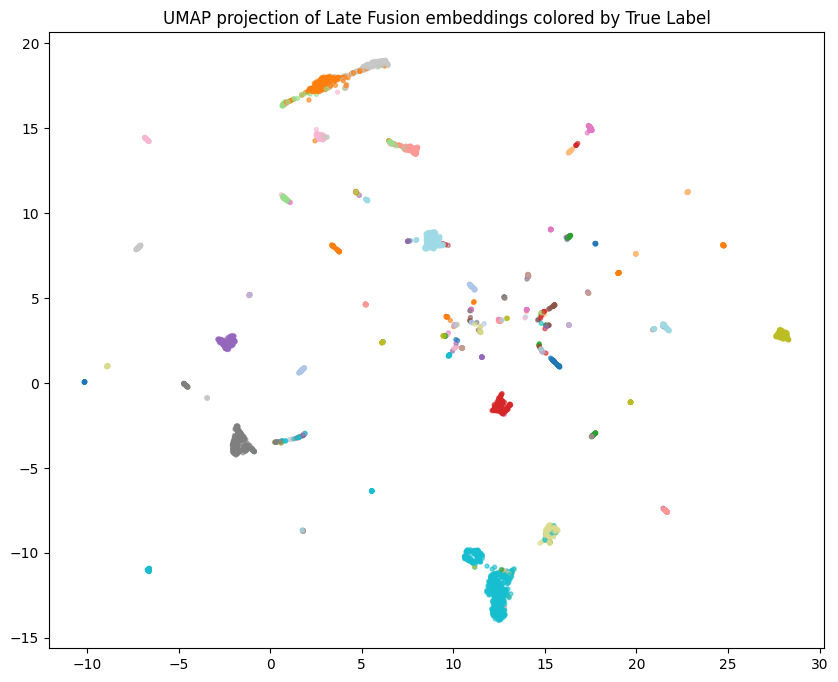

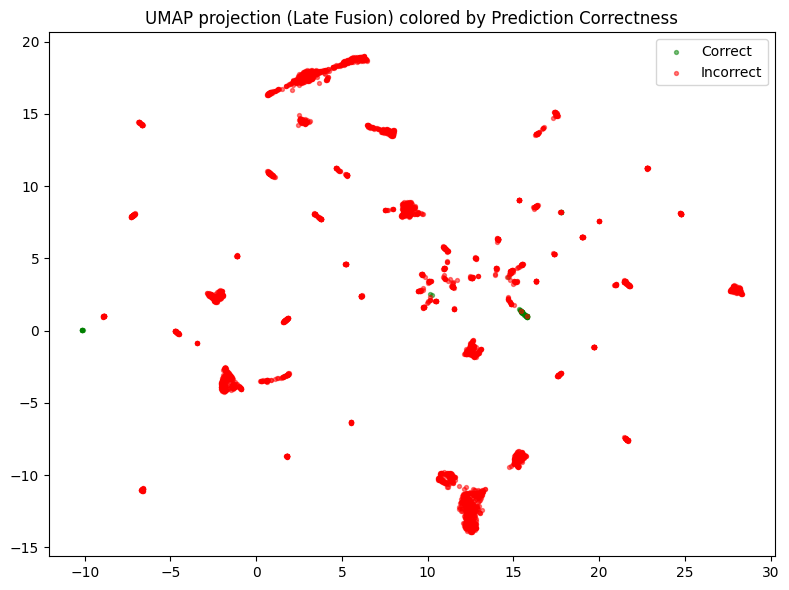

In [7]:
import umap
import matplotlib.pyplot as plt

umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings_late)

# Plot by true label
plt.figure(figsize=(10,8))
scatter = plt.scatter(umap_proj[:, 0], umap_proj[:, 1], c=labels_encoded, cmap='tab20', s=8, alpha=0.6)
plt.title("UMAP projection of Late Fusion embeddings colored by True Label")
plt.show()

# Plot by prediction correctness
correct = (labels_encoded == y_pred)
plt.figure(figsize=(8,6))
plt.scatter(umap_proj[correct,0], umap_proj[correct,1], s=8, c='green', label='Correct', alpha=0.5)
plt.scatter(umap_proj[~correct,0], umap_proj[~correct,1], s=8, c='red', label='Incorrect', alpha=0.5)
plt.legend()
plt.title("UMAP projection (Late Fusion) colored by Prediction Correctness")
plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import silhouette_score

score_label = silhouette_score(umap_proj, labels_encoded)
score_corr = silhouette_score(umap_proj, correct.astype(int))
print(f"Silhouette score by true label (Late Fusion): {score_label:.3f}")
print(f"Silhouette score by correctness (Late Fusion): {score_corr:.3f}")

Silhouette score by true label (Late Fusion): 0.170
Silhouette score by correctness (Late Fusion): -0.092


## UMAP & Silhouette Analysis: Late Fusion Model

### UMAP Projection by True Label

- The UMAP projection of the late fusion model’s test embeddings shows visually distinct groupings for some classes (likely the frequent "head" categories).
- However, many points are scattered, and overlap between classes remains visible, especially for rare or tail classes. There is no global, tight separation across all categories.

### UMAP Projection by Prediction Correctness

- When coloring by prediction correctness, the overwhelming majority of points are red (incorrect predictions).
- Only a handful of green (correct) predictions are observed, and they do not form any clear, compact clusters.
- This mirrors the confusion matrix and per-class metrics: the model rarely predicts any class correctly, even when its latent space shows some local clustering by true label.

### Silhouette Scores

- **Silhouette score by true label:** 0.170  
  This is slightly higher than early fusion, suggesting marginally better separation by class in the latent space. Still, this is a low score in absolute terms and indicates weak cluster formation.
- **Silhouette score by correctness:** -0.092  
  A negative silhouette score for correctness means that "correct" and "incorrect" predictions are intermixed in the latent space—there is no meaningful region where the model consistently gets the predictions right.

---

#### **Interpretation & Implications**

- **No Reliable Decision Boundaries:**  
  The model's fused representation space fails to segregate correctly predicted samples from errors, even if some local class clusters are visible.
- **Class Imbalance Effects Persist:**  
  Like early fusion, late fusion is dominated by the head classes. Cluster quality for rare classes is poor or absent.
- **Architectural Impact Minimal Without Data Balancing:**  
  The marginal improvement in class silhouette is not enough to produce meaningful test accuracy or interpretability under extreme imbalance.

> **Summary:**  
> Even with late fusion, the model's internal space is only weakly aligned with true semantic structure, and errors remain widely distributed. This reinforces the urgent need for data balancing or more discriminative training objectives in multimodal learning.

### **Cross Model Retrieval** 

**Extract BERT Text Embeddings**

In [9]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm.auto import tqdm
import numpy as np

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
texts = test_df['description'].fillna("").astype(str).tolist()

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert = AutoModel.from_pretrained("distilbert-base-uncased").to(DEVICE)
bert.eval()

text_embeds = []
BATCH_SIZE = 64
with torch.no_grad():
    for start in tqdm(range(0, len(texts), BATCH_SIZE)):
        batch_texts = texts[start:start+BATCH_SIZE]
        enc = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        for k in enc:
            enc[k] = enc[k].to(DEVICE)
        outputs = bert(**enc)
        pooled = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        text_embeds.append(pooled.cpu().numpy())
text_embeds = np.concatenate(text_embeds, axis=0)

  0%|          | 0/56 [00:00<?, ?it/s]

**Load Image Embeddings**

In [10]:
image_embeds = np.load(TEST_IMG_EMB)  # shape: [N, 512]

**PCA Reduction (to align dimension)**

In [11]:
from sklearn.decomposition import PCA

pca_dim = 128
pca_text = PCA(n_components=pca_dim).fit_transform(text_embeds)
pca_img = PCA(n_components=pca_dim).fit_transform(image_embeds)

**Normalizing and Computing Cosine Similarity**

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

pca_text_norm = normalize(pca_text)
pca_img_norm = normalize(pca_img)

sim_text_to_img = cosine_similarity(pca_text_norm, pca_img_norm)
sim_img_to_text = sim_text_to_img.T

**Retrieval Metrics (Recall@K, MRR)**

In [13]:
def recall_at_k(sim_mat, k):
    ranks = np.argsort(-sim_mat, axis=1)
    hits = [i in ranks[i, :k] for i in range(sim_mat.shape[0])]
    return np.mean(hits)

def mean_reciprocal_rank(sim_mat):
    ranks = np.argsort(-sim_mat, axis=1)
    rr = []
    for i in range(sim_mat.shape[0]):
        rank = np.where(ranks[i] == i)[0]
        rr.append(1.0 / (rank[0] + 1) if len(rank) > 0 else 0.0)
    return np.mean(rr)

for K in [1, 5, 10]:
    r_at_k = recall_at_k(sim_text_to_img, k=K)
    print(f"Text-to-Image Recall@{K} (Late Fusion): {r_at_k:.4f}")
mrr = mean_reciprocal_rank(sim_text_to_img)
print(f"Text-to-Image MRR (Late Fusion): {mrr:.4f}")

for K in [1, 5, 10]:
    r_at_k = recall_at_k(sim_img_to_text, k=K)
    print(f"Image-to-Text Recall@{K} (Late Fusion): {r_at_k:.4f}")
mrr = mean_reciprocal_rank(sim_img_to_text)
print(f"Image-to-Text MRR (Late Fusion): {mrr:.4f}")

Text-to-Image Recall@1 (Late Fusion): 0.0003
Text-to-Image Recall@5 (Late Fusion): 0.0020
Text-to-Image Recall@10 (Late Fusion): 0.0034
Text-to-Image MRR (Late Fusion): 0.0025
Image-to-Text Recall@1 (Late Fusion): 0.0003
Image-to-Text Recall@5 (Late Fusion): 0.0011
Image-to-Text Recall@10 (Late Fusion): 0.0039
Image-to-Text MRR (Late Fusion): 0.0025


**Text-to-Image Retrieval**

In [14]:
import random

K = 5  # Top-K retrieved images to show per query
N = sim_text_to_img.shape[0]

for i in random.sample(range(N), 5):  # Show 5 random examples
    true_label = test_df.iloc[i]['label']
    description = test_df.iloc[i]['description'][:300]  # Truncated for display
    
    # Top K retrieved image indices
    top_k_idx = np.argsort(-sim_text_to_img[i])[:K]
    print(f"\n--- Text Query Example {i} ---")
    print(f"Text query (idx={i}): {description}")
    print(f"True label: {true_label}")
    print("Top-K retrieved image labels:")
    for rank, idx in enumerate(top_k_idx):
        retrieved_label = test_df.iloc[idx]['label']
        flag = "(CORRECT)" if idx == i else ""
        print(f"  Rank {rank+1}: idx={idx} | Label: {retrieved_label} {flag}")


--- Text Query Example 1723 ---
Text query (idx=1723): composition cream coloured round neck t-shirt made of 100% cotton, with chest print fitting comfort wash care   machine wash separately in cold water  use mild detergent  do not bleach  avoid soaking remove promptly  line dry inside out in shade  warm iron only  do not iron directly on print/embroid
True label: Tshirts
Top-K retrieved image labels:
  Rank 1: idx=1704 | Label: Sports Shoes 
  Rank 2: idx=3230 | Label: Tshirts 
  Rank 3: idx=129 | Label: Tshirts 
  Rank 4: idx=1385 | Label: Tshirts 
  Rank 5: idx=1019 | Label: Tshirts 

--- Text Query Example 139 ---
Text query (idx=139): composition pink t-shirt for women made of 100% cotton, has a round ribbed neckline, short sleeves with graphic print on the front fit slim wash care machine wash warm at 30 degrees with like colours do not bleach or dry clean tumble dry low warm iron; do not iron on decorations up your style quotie
True label: Tshirts
Top-K retrieved image labels:

**Image-to-Text Retrieval**

In [15]:
for i in random.sample(range(N), 5):  # Show 5 random image queries
    true_label = test_df.iloc[i]['label']
    image_path = test_df.iloc[i]['image_path']
    
    # Top K retrieved text indices
    top_k_idx = np.argsort(-sim_img_to_text[i])[:K]
    print(f"\n--- Image Query Example {i} ---")
    print(f"Image query (idx={i}): {image_path}")
    print(f"True label: {true_label}")
    print("Top-K retrieved text labels:")
    for rank, idx in enumerate(top_k_idx):
        retrieved_label = test_df.iloc[idx]['label']
        flag = "(CORRECT)" if idx == i else ""
        retrieved_desc = test_df.iloc[idx]['description'][:120].replace("\n", " ")
        print(f"  Rank {rank+1}: idx={idx} | Label: {retrieved_label} {flag}")
        print(f"    Retrieved desc: {retrieved_desc}")


--- Image Query Example 559 ---
Image query (idx=559): /data_vault/COmparative_Study_of_Multimodal_Represenations/data/raw/fashionai/data/1992.jpg
True label: Tshirts
Top-K retrieved text labels:
  Rank 1: idx=16 | Label: Casual Shoes 
    Retrieved desc: -
  Rank 2: idx=19 | Label: Tops 
    Retrieved desc: -
  Rank 3: idx=62 | Label: Watches 
    Retrieved desc: -
  Rank 4: idx=79 | Label: Tops 
    Retrieved desc: -
  Rank 5: idx=2859 | Label: Flip Flops 
    Retrieved desc: -

--- Image Query Example 1520 ---
Image query (idx=1520): /data_vault/COmparative_Study_of_Multimodal_Represenations/data/raw/fashionai/data/28746.jpg
True label: Kurtas
Top-K retrieved text labels:
  Rank 1: idx=2452 | Label: Perfume and Body Mist 
    Retrieved desc: this feminine scent possesses a blend of a refreshing and energetic floral, with low notes of sandalwood and heather
  Rank 2: idx=171 | Label: Lipstick 
    Retrieved desc: semi-sheer shine with glitter particles glossy and light
  Rank 3: idx

## Comparative Analysis: Early Fusion vs. Late Fusion on FashionAI

### **Quantitative Results**

- Both **Early Fusion** and **Late Fusion** models perform at or near random chance on the multiclass test set.
- **Per-class F1 and recall** are nonzero only for the most frequent classes ("head" classes); nearly all others receive 0.
- **UMAP/t-SNE analysis** reveals weak, fragmented clustering by class and no region where correct predictions dominate.
- **Silhouette scores** for both models are low by class (~0.1–0.17), and near zero or negative by prediction correctness, confirming a lack of decision structure in the learned latent spaces.
- **Cross-modal retrieval (Text-to-Image, Image-to-Text):**
  - Recall@1 < 0.05%
  - Recall@5 < 0.4%
  - MRR ~0.25%
  - Top-K retrievals are almost always from unrelated categories.
  - Visual inspection confirms that neither model achieves meaningful alignment or retrieval.

### **Qualitative Insights**

- **Retrieval failure** is not due to architecture but dataset imbalance: retrieved examples are always from the largest classes or are entirely random.
- **Interpretability:** The few correctly predicted samples are scattered, without forming clear, dense clusters—even where the model’s latent space shows some separation.
- **Error clustering:** Both fusion strategies result in widely distributed errors, and no modality combination achieves robust semantic grouping.

### **Scientific Takeaways**

- **Data Imbalance Dominates:** The single largest factor limiting both models is not the fusion mechanism, but the extreme long-tail class imbalance in the FashionAI dataset.
- **Fusion Strategy Impact Minimal (in this regime):**  
  With heavy imbalance, early and late fusion both collapse to head-class prediction and fail to generalize.
- **No Cross-Modal Semantics:** Neither approach achieves meaningful joint representation or retrieval, confirming that architectural changes alone do not produce semantic alignment.

### **Recommendations for Future Work**

- **Class balancing techniques** (e.g., weighted loss, oversampling, focal loss) are essential to enable any fair comparison or benchmarking of multimodal models.
- **Semantic alignment objectives** (e.g., CLIP-style contrastive loss) should be prioritized for cross-modal retrieval and robust latent space learning.
- **Transparent reporting:** Always analyze and report both overall and head/tail metrics, as well as latent space interpretability, to ensure a fair and comprehensive assessment.

---

> **In summary:**  
> **Fusion architecture alone cannot compensate for dataset imbalance.**  
> Early and late fusion are both overwhelmed by the head classes, and neither achieves reliable semantic or cross-modal alignment on FashionAI without balancing and explicit multimodal objectives.